In [2]:
import torch
import torch.optim as optim

import pandas as pd
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchinfo import summary

from src.datasets import IrmaDataset
from src.transforms import MinMaxScaler, Sobel, Laplacian, GammaCorrection, HistogramEqualizer
from src.models import VAE, PVAE
from src.utils.model_utils import train_val_split, get_latent, predict
from src.utils.visualization import (
    plot_reconstructions,
    plot_2d,
    sample_images,
    plot_history,
)
from src.utils.training_funcs import (
    train,
    validate,
    pred_kl_reconstruction_loss,
    kl_reconstruction_loss,
    get_metrics_str,
    pred_loss,
)

In [3]:
torch.backends.cudnn.benchmark = True

In [4]:
batch_size = 32

In [4]:
ex_images = []

# Simple Dataset

In [5]:
dataset = IrmaDataset(
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            MinMaxScaler()
        ]
    ),
    return_images=True,
)

datasets = train_val_split(dataset, 0.1, random_state=7)
datasets['test'] = datasets['val']
datasets = {**datasets, **train_val_split(datasets['train'], 0.1 / 0.9, random_state=7)}

dataloaders = {
    x: DataLoader(datasets[x], batch_size, shuffle=True)
    for x in ['train', 'test', 'val']
}

len(datasets['train']), len(datasets['test']), len(datasets['val'])

(4018, 503, 503)

In [6]:
def get_sample_images(ds):
    found = set()
    images = [None for _ in range(4)]
    for d, l in ds:
        lbl = l.item()
        if lbl not in found:
            images[lbl] = (d, l)
            found.add(lbl)
        if len(found) >= 4:
            break

    return images

In [7]:
ex_images.append(get_sample_images(datasets['test']))

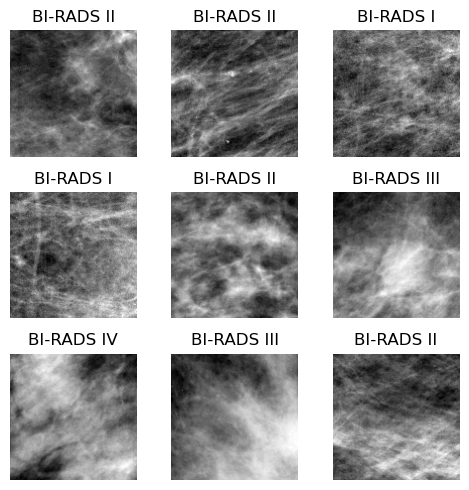

In [5]:
sample_images(dataloaders['train'], label_mapper=IrmaDataset.get_class_label, plot_borders=False)

## VAE

In [6]:
model = VAE(
    latent_dim=64,
    conv_layers=[(5, 192), (3, 128), (3, 96), (3, 64)],
    conv_pooling=[2, 2, 2, 2],
    linear_input=(64, 6, 6),
    linear_layers=[256, 128, 64],
    clamp_output=False,
    use_batchnorm=True
)
summary(model, input_size=(32, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [32, 1, 128, 128]         --
├─Encoder: 1-1                           [32, 64]                  --
│    └─Sequential: 2-1                   [32, 64, 6, 6]            --
│    │    └─Conv2d: 3-1                  [32, 192, 124, 124]       4,992
│    │    └─BatchNorm2d: 3-2             [32, 192, 124, 124]       384
│    │    └─GELU: 3-3                    [32, 192, 124, 124]       --
│    │    └─MaxPool2d: 3-4               [32, 192, 62, 62]         --
│    │    └─Conv2d: 3-5                  [32, 128, 60, 60]         221,312
│    │    └─BatchNorm2d: 3-6             [32, 128, 60, 60]         256
│    │    └─GELU: 3-7                    [32, 128, 60, 60]         --
│    │    └─MaxPool2d: 3-8               [32, 128, 30, 30]         --
│    │    └─Conv2d: 3-9                  [32, 96, 28, 28]          110,688
│    │    └─BatchNorm2d: 3-10            [32, 96, 28, 28]          192

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(model.parameters())
model.to(device)

hist = train(model, optimizer, dataloaders['train'], dataloaders['val'], 32, kl_reconstruction_loss)

[epoch: 1] train_loss: 12.8007 - train_rec_loss: 12.7592 - train_kl_loss: 0.0415 - val_loss: 4.4657 - val_rec_loss: 4.4180 - val_kl_loss: 0.0478
[epoch: 2] train_loss: 3.6565 - train_rec_loss: 3.6009 - train_kl_loss: 0.0556 - val_loss: 2.8141 - val_rec_loss: 2.7471 - val_kl_loss: 0.0670
[epoch: 3] train_loss: 2.5807 - train_rec_loss: 2.5209 - train_kl_loss: 0.0598 - val_loss: 2.3670 - val_rec_loss: 2.3097 - val_kl_loss: 0.0573
[epoch: 4] train_loss: 2.3584 - train_rec_loss: 2.3047 - train_kl_loss: 0.0537 - val_loss: 2.2920 - val_rec_loss: 2.2392 - val_kl_loss: 0.0528
[epoch: 5] train_loss: 2.2346 - train_rec_loss: 2.1819 - train_kl_loss: 0.0528 - val_loss: 2.0970 - val_rec_loss: 2.0407 - val_kl_loss: 0.0563
[epoch: 6] train_loss: 2.0448 - train_rec_loss: 1.9889 - train_kl_loss: 0.0559 - val_loss: 1.9376 - val_rec_loss: 1.8799 - val_kl_loss: 0.0577
[epoch: 7] train_loss: 1.9154 - train_rec_loss: 1.8591 - train_kl_loss: 0.0563 - val_loss: 1.8621 - val_rec_loss: 1.8084 - val_kl_loss: 0.05

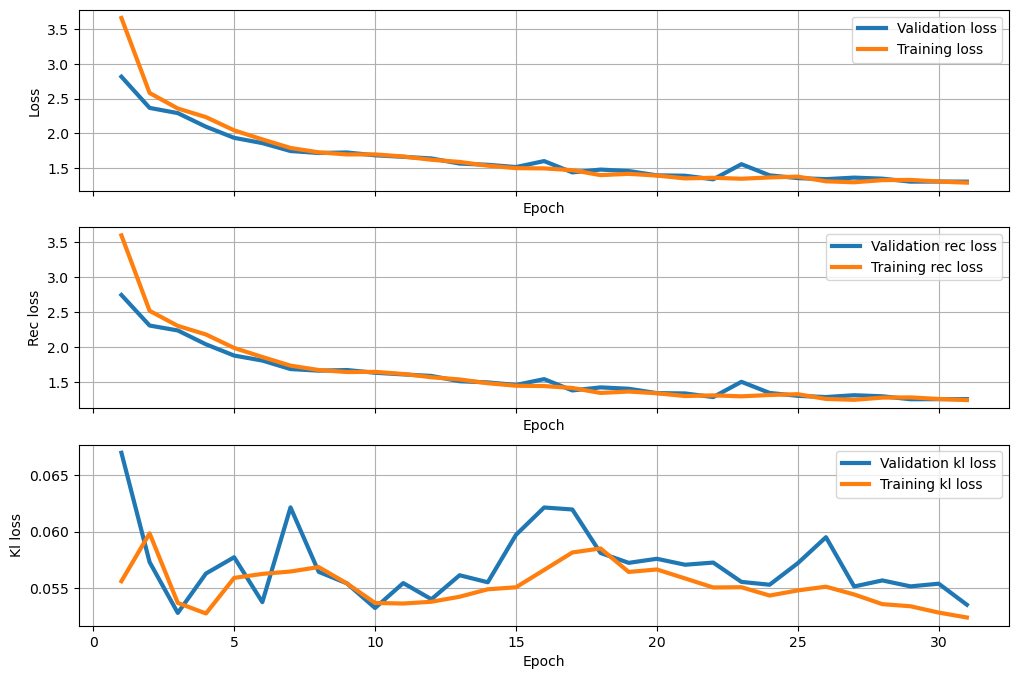

In [8]:
plot_history(hist[1:])

In [9]:
torch.save((model.kwargs ,model.state_dict()), "models/final/simple/vae.pt")

test_loss: 1.2765 - test_rec_loss: 1.2237 - test_kl_loss: 0.0528


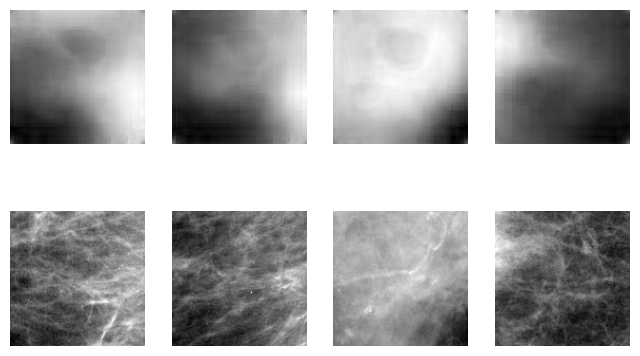

In [10]:
test_metrics = validate(model, dataloaders['test'], kl_reconstruction_loss)

print(get_metrics_str(test_metrics, 'test_'))

plot_reconstructions(model, dataloaders['test'])

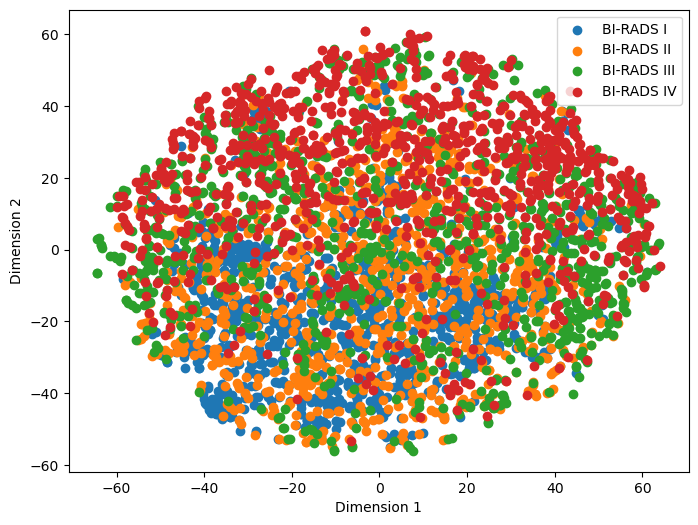

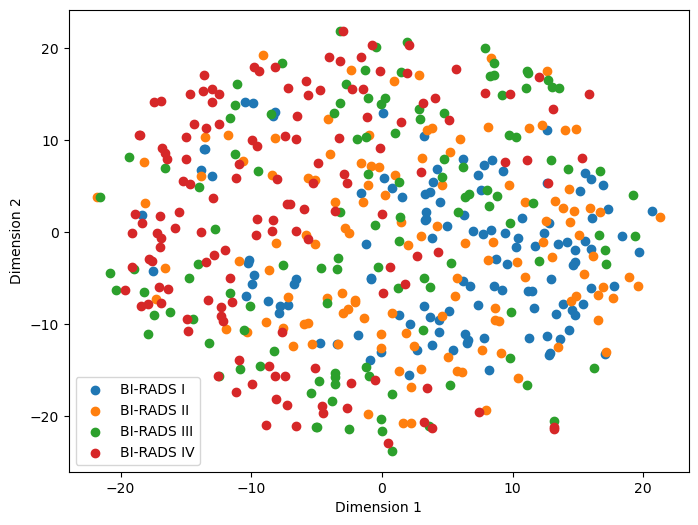

In [11]:
train_latent, train_labels = get_latent(model, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(model, dataloaders["test"], IrmaDataset.get_class_label)

tsne = TSNE()
train_tsne_latent = tsne.fit_transform(train_latent, train_labels)
tsne_latent = tsne.fit_transform(latent)

plot_2d(train_tsne_latent, train_labels, 'tab10', IrmaDataset.get_class_label_value)
plot_2d(tsne_latent, labels, 'tab10', IrmaDataset.get_class_label_value)

In [12]:
train_latent, train_labels = get_latent(model, dataloaders["train"])
val_latent, val_labels = get_latent(model, dataloaders["val"])
latent, labels = get_latent(model, dataloaders["test"])

In [13]:
train_latent, train_labels = train_latent.astype('float32'), train_labels.astype('int64')
val_latent, val_labels = val_latent.astype('float32'), val_labels.astype('int64')
latent, labels = latent.astype('float32'), labels.astype('int64')

In [14]:
train_ds = TensorDataset(torch.tensor(train_latent), torch.tensor(train_labels))
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

val_ds = TensorDataset(torch.tensor(val_latent), torch.tensor(val_labels))
val_dl = DataLoader(val_ds, batch_size)

test_ds = TensorDataset(torch.tensor(latent), torch.tensor(labels))
test_dl = DataLoader(test_ds, batch_size)

In [15]:
pred_model = torch.nn.Sequential(
    torch.nn.Linear(64, 128),
    torch.nn.GELU(),
    torch.nn.Linear(128, 256),
    torch.nn.GELU(),
    torch.nn.Linear(256, 128),
    torch.nn.GELU(),
    torch.nn.Linear(128, 64),
    torch.nn.GELU(),
    torch.nn.Linear(64, 4),
    torch.nn.Softmax(-1)
)

summary(pred_model, (32, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 4]                   --
├─Linear: 1-1                            [32, 128]                 8,320
├─GELU: 1-2                              [32, 128]                 --
├─Linear: 1-3                            [32, 256]                 33,024
├─GELU: 1-4                              [32, 256]                 --
├─Linear: 1-5                            [32, 128]                 32,896
├─GELU: 1-6                              [32, 128]                 --
├─Linear: 1-7                            [32, 64]                  8,256
├─GELU: 1-8                              [32, 64]                  --
├─Linear: 1-9                            [32, 4]                   260
├─Softmax: 1-10                          [32, 4]                   --
Total params: 82,756
Trainable params: 82,756
Non-trainable params: 0
Total mult-adds (M): 2.65
Input size (MB): 0.01
Forward/backward pass 

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(pred_model.parameters(), lr=0.00002)
pred_model.to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

hist = train(pred_model, optimizer, train_dl, val_dl, 64, pred_loss)

[epoch: 1] train_loss: 1.3858 - train_predict_loss: 1.3858 - train_accuracy: 0.2618 - val_loss: 1.3846 - val_predict_loss: 1.3846 - val_accuracy: 0.3439
[epoch: 2] train_loss: 1.3835 - train_predict_loss: 1.3835 - train_accuracy: 0.3718 - val_loss: 1.3813 - val_predict_loss: 1.3813 - val_accuracy: 0.4076
[epoch: 3] train_loss: 1.3760 - train_predict_loss: 1.3760 - train_accuracy: 0.3790 - val_loss: 1.3681 - val_predict_loss: 1.3681 - val_accuracy: 0.3678
[epoch: 4] train_loss: 1.3489 - train_predict_loss: 1.3489 - train_accuracy: 0.3571 - val_loss: 1.3348 - val_predict_loss: 1.3348 - val_accuracy: 0.3598
[epoch: 5] train_loss: 1.3158 - train_predict_loss: 1.3158 - train_accuracy: 0.3644 - val_loss: 1.3137 - val_predict_loss: 1.3137 - val_accuracy: 0.4135
[epoch: 6] train_loss: 1.2970 - train_predict_loss: 1.2970 - train_accuracy: 0.4176 - val_loss: 1.2964 - val_predict_loss: 1.2964 - val_accuracy: 0.4553
[epoch: 7] train_loss: 1.2826 - train_predict_loss: 1.2826 - train_accuracy: 0.439

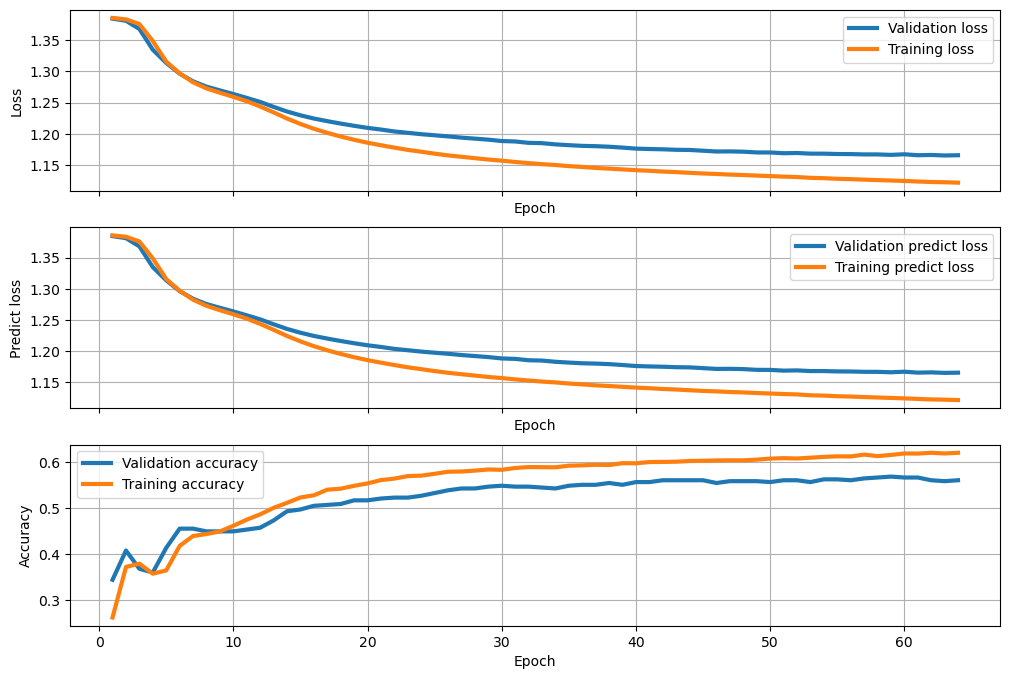

In [17]:
plot_history(hist)

In [18]:
test_metrics = validate(pred_model, test_dl, pred_loss)

print(get_metrics_str(test_metrics, 'test_'))

test_loss: 1.1660 - test_predict_loss: 1.1660 - test_accuracy: 0.5686


In [19]:
y_pred, y_true = predict(pred_model, test_dl, return_class=True)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.72      0.71       121
           1       0.50      0.52      0.51       124
           2       0.47      0.41      0.44       119
           3       0.59      0.62      0.60       139

    accuracy                           0.57       503
   macro avg       0.56      0.57      0.56       503
weighted avg       0.57      0.57      0.57       503



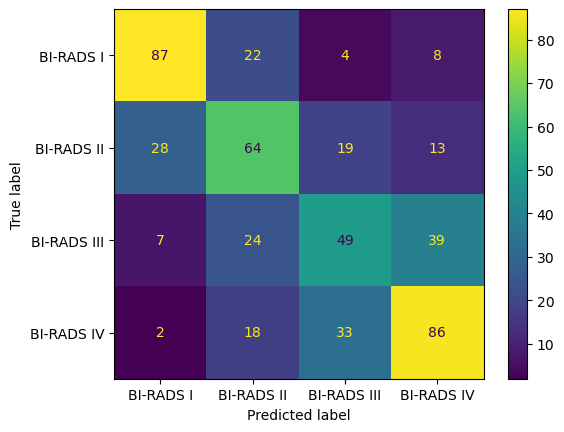

In [20]:
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=IrmaDataset.irma_classmap.classes_
)
cm_display.plot()

## PVAE

In [274]:
model = PVAE(
    latent_dim=64,
    n_classes=4,
    conv_layers=[(5, 192), (3, 128), (3, 96), (3, 64)],
    conv_pooling=[2, 2, 2, 2],
    linear_input=(64, 6, 6),
    linear_layers=[256, 128, 64],
    pred_layers=[128, 64],
    clamp_output=False,
    use_batchnorm=False
)
summary(model, input_size=(32, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
PVAE                                     [32, 1, 128, 128]         --
├─Encoder: 1-1                           [32, 64]                  --
│    └─Sequential: 2-1                   [32, 64, 6, 6]            --
│    │    └─Conv2d: 3-1                  [32, 192, 124, 124]       4,992
│    │    └─GELU: 3-2                    [32, 192, 124, 124]       --
│    │    └─MaxPool2d: 3-3               [32, 192, 62, 62]         --
│    │    └─Conv2d: 3-4                  [32, 128, 60, 60]         221,312
│    │    └─GELU: 3-5                    [32, 128, 60, 60]         --
│    │    └─MaxPool2d: 3-6               [32, 128, 30, 30]         --
│    │    └─Conv2d: 3-7                  [32, 96, 28, 28]          110,688
│    │    └─GELU: 3-8                    [32, 96, 28, 28]          --
│    │    └─MaxPool2d: 3-9               [32, 96, 14, 14]          --
│    │    └─Conv2d: 3-10                 [32, 64, 12, 12]          55,36

In [275]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(model.parameters())
model.to(device)

hist = train(model, optimizer, dataloaders['train'], dataloaders['val'], 32, pred_kl_reconstruction_loss)

KeyboardInterrupt: 

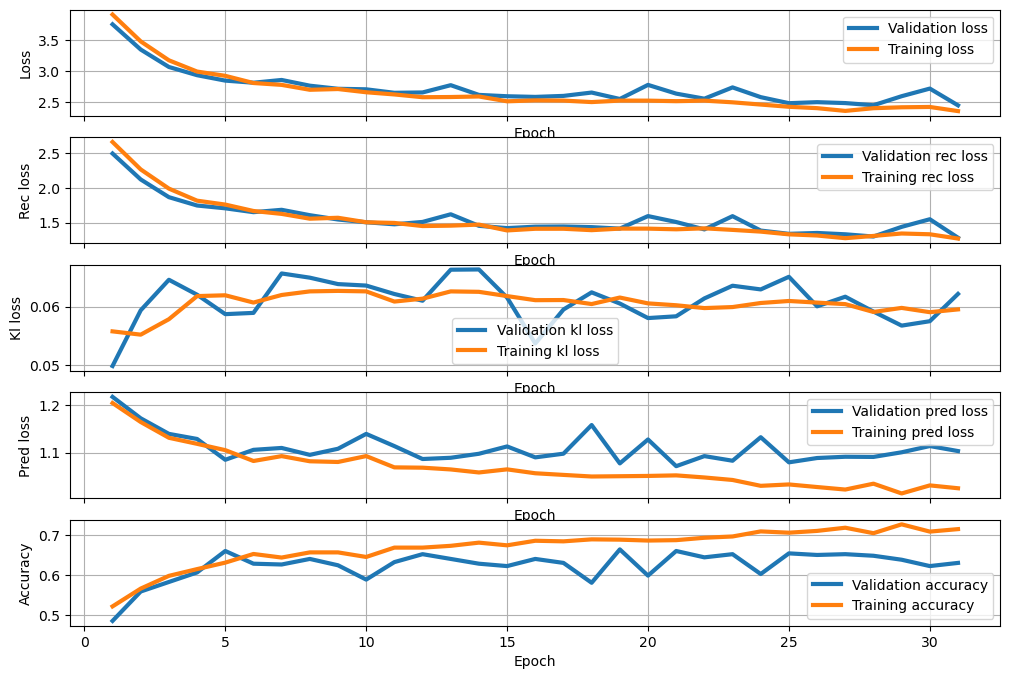

In [ ]:
plot_history(hist[1:])

In [24]:
torch.save((model.kwargs ,model.state_dict()), "models/final/simple/pvae.pt")

test_loss: 2.5049 - test_rec_loss: 1.3010 - test_kl_loss: 0.0623 - test_pred_loss: 1.1415 - test_accuracy: 0.5964


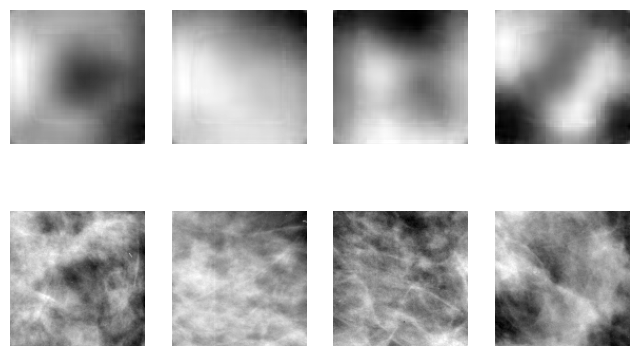

In [25]:
test_metrics = validate(model, dataloaders['test'], pred_kl_reconstruction_loss)

print(get_metrics_str(test_metrics, 'test_'))

plot_reconstructions(model, dataloaders['test'])

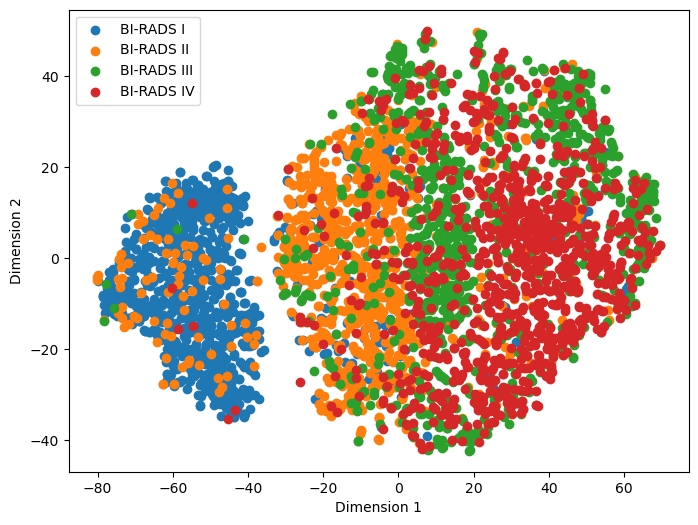

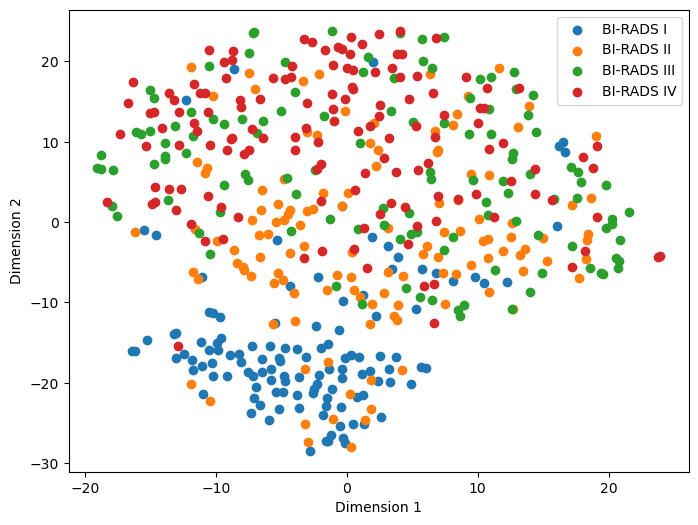

In [26]:
train_latent, train_labels = get_latent(model, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(model, dataloaders["test"], IrmaDataset.get_class_label)

tsne = TSNE()
train_tsne_latent = tsne.fit_transform(train_latent, train_labels)
tsne_latent = tsne.fit_transform(latent)

plot_2d(train_tsne_latent, train_labels, 'tab10', IrmaDataset.get_class_label_value)
plot_2d(tsne_latent, labels, 'tab10', IrmaDataset.get_class_label_value)

In [27]:
train_latent, train_labels = get_latent(model, dataloaders["train"])
val_latent, val_labels = get_latent(model, dataloaders["val"])
latent, labels = get_latent(model, dataloaders["test"])

In [28]:
train_latent, train_labels = train_latent.astype('float32'), train_labels.astype('int64')
val_latent, val_labels = val_latent.astype('float32'), val_labels.astype('int64')
latent, labels = latent.astype('float32'), labels.astype('int64')

In [29]:
train_ds = TensorDataset(torch.tensor(train_latent), torch.tensor(train_labels))
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

val_ds = TensorDataset(torch.tensor(val_latent), torch.tensor(val_labels))
val_dl = DataLoader(val_ds, batch_size)

test_ds = TensorDataset(torch.tensor(latent), torch.tensor(labels))
test_dl = DataLoader(test_ds, batch_size)

In [30]:
pred_model = torch.nn.Sequential(
    torch.nn.Linear(64, 128),
    torch.nn.GELU(),
    torch.nn.Linear(128, 256),
    torch.nn.GELU(),
    torch.nn.Linear(256, 128),
    torch.nn.GELU(),
    torch.nn.Linear(128, 64),
    torch.nn.GELU(),
    torch.nn.Linear(64, 4),
    torch.nn.Softmax(-1)
)

summary(pred_model, (32, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 4]                   --
├─Linear: 1-1                            [32, 128]                 8,320
├─GELU: 1-2                              [32, 128]                 --
├─Linear: 1-3                            [32, 256]                 33,024
├─GELU: 1-4                              [32, 256]                 --
├─Linear: 1-5                            [32, 128]                 32,896
├─GELU: 1-6                              [32, 128]                 --
├─Linear: 1-7                            [32, 64]                  8,256
├─GELU: 1-8                              [32, 64]                  --
├─Linear: 1-9                            [32, 4]                   260
├─Softmax: 1-10                          [32, 4]                   --
Total params: 82,756
Trainable params: 82,756
Non-trainable params: 0
Total mult-adds (M): 2.65
Input size (MB): 0.01
Forward/backward pass 

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(pred_model.parameters(), lr=0.00002)
pred_model.to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

hist = train(pred_model, optimizer, train_dl, val_dl, 64, pred_loss)

[epoch: 1] train_loss: 1.3849 - train_predict_loss: 1.3849 - train_accuracy: 0.2539 - val_loss: 1.3844 - val_predict_loss: 1.3844 - val_accuracy: 0.2326
[epoch: 2] train_loss: 1.3798 - train_predict_loss: 1.3798 - train_accuracy: 0.2539 - val_loss: 1.3767 - val_predict_loss: 1.3767 - val_accuracy: 0.2326
[epoch: 3] train_loss: 1.3624 - train_predict_loss: 1.3624 - train_accuracy: 0.4241 - val_loss: 1.3464 - val_predict_loss: 1.3464 - val_accuracy: 0.5089
[epoch: 4] train_loss: 1.3009 - train_predict_loss: 1.3009 - train_accuracy: 0.5941 - val_loss: 1.2649 - val_predict_loss: 1.2649 - val_accuracy: 0.5388
[epoch: 5] train_loss: 1.2041 - train_predict_loss: 1.2041 - train_accuracy: 0.6040 - val_loss: 1.1905 - val_predict_loss: 1.1905 - val_accuracy: 0.5785
[epoch: 6] train_loss: 1.1398 - train_predict_loss: 1.1398 - train_accuracy: 0.6658 - val_loss: 1.1504 - val_predict_loss: 1.1504 - val_accuracy: 0.6282
[epoch: 7] train_loss: 1.0877 - train_predict_loss: 1.0877 - train_accuracy: 0.715

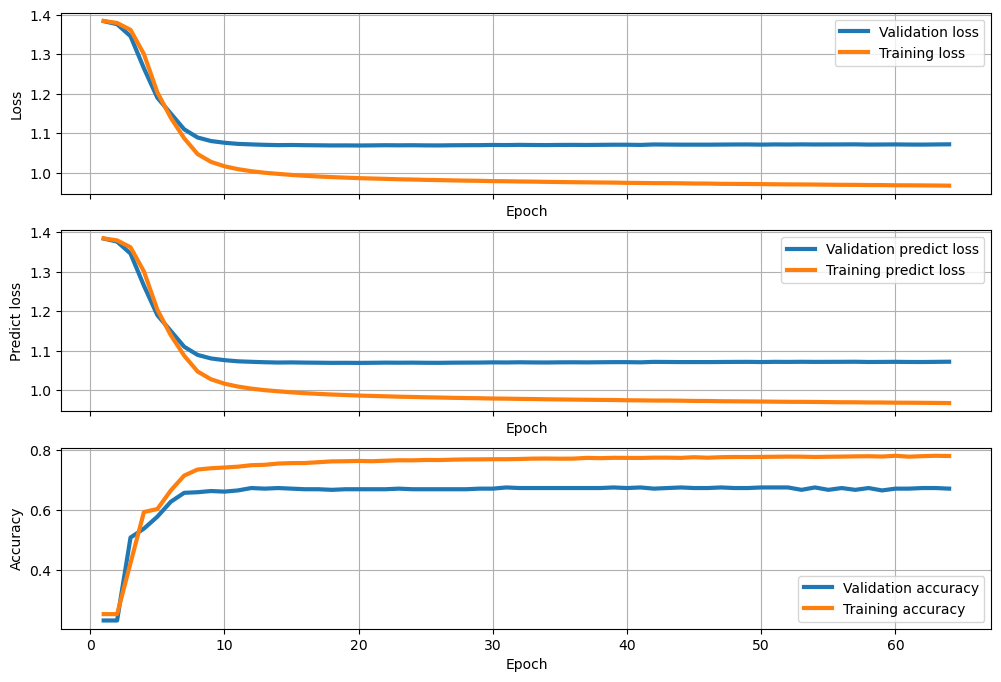

In [32]:
plot_history(hist)

In [33]:
test_metrics = validate(pred_model, test_dl, pred_loss)

print(get_metrics_str(test_metrics, 'test_'))

test_loss: 1.0890 - test_predict_loss: 1.0890 - test_accuracy: 0.6481


In [34]:
y_pred, y_true = predict(pred_model, test_dl, return_class=True)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       121
           1       0.57      0.62      0.59       124
           2       0.56      0.50      0.53       119
           3       0.62      0.63      0.62       139

    accuracy                           0.65       503
   macro avg       0.65      0.65      0.65       503
weighted avg       0.65      0.65      0.65       503



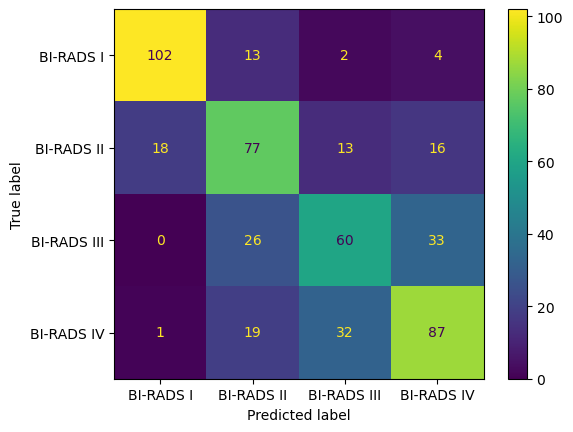

In [35]:
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=IrmaDataset.irma_classmap.classes_
)
cm_display.plot()

# Sobel Dataset

In [8]:
dataset = IrmaDataset(
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            MinMaxScaler(),
            Sobel(),
            MinMaxScaler()
        ]
    ),
    return_images=True,
)

datasets = train_val_split(dataset, 0.1, random_state=7)
datasets['test'] = datasets['val']
datasets = {**datasets, **train_val_split(datasets['train'], 0.1 / 0.9, random_state=7)}

dataloaders = {
    x: DataLoader(datasets[x], batch_size, shuffle=True)
    for x in ['train', 'test', 'val']
}

len(datasets['train']), len(datasets['test']), len(datasets['val'])

(4018, 503, 503)

In [9]:
ex_images.append(get_sample_images(datasets['test']))

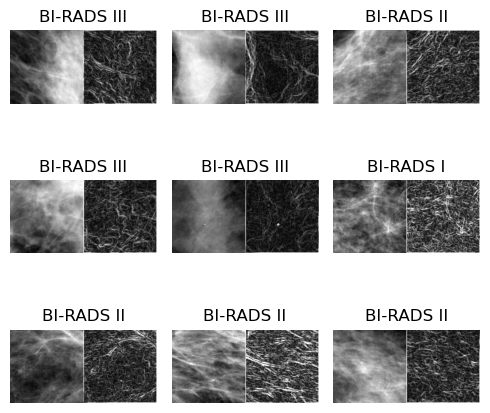

In [37]:
sample_images(dataloaders['train'], label_mapper=IrmaDataset.get_class_label, plot_borders=True)

## VAE

In [38]:
model = VAE(
    latent_dim=64,
    n_channels=2,
    conv_layers=[(5, 192), (3, 128), (3, 96), (3, 64)],
    conv_pooling=[2, 2, 2, 2],
    linear_input=(64, 6, 6),
    linear_layers=[256, 128, 64],
    clamp_output=False,
    use_batchnorm=True
)
summary(model, input_size=(32, 2, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [32, 2, 128, 128]         --
├─Encoder: 1-1                           [32, 64]                  --
│    └─Sequential: 2-1                   [32, 64, 6, 6]            --
│    │    └─Conv2d: 3-1                  [32, 192, 124, 124]       9,792
│    │    └─BatchNorm2d: 3-2             [32, 192, 124, 124]       384
│    │    └─GELU: 3-3                    [32, 192, 124, 124]       --
│    │    └─MaxPool2d: 3-4               [32, 192, 62, 62]         --
│    │    └─Conv2d: 3-5                  [32, 128, 60, 60]         221,312
│    │    └─BatchNorm2d: 3-6             [32, 128, 60, 60]         256
│    │    └─GELU: 3-7                    [32, 128, 60, 60]         --
│    │    └─MaxPool2d: 3-8               [32, 128, 30, 30]         --
│    │    └─Conv2d: 3-9                  [32, 96, 28, 28]          110,688
│    │    └─BatchNorm2d: 3-10            [32, 96, 28, 28]          192

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(model.parameters())
model.to(device)

hist = train(model, optimizer, dataloaders['train'], dataloaders['val'], 32, kl_reconstruction_loss)

[epoch: 1] train_loss: 9.7745 - train_rec_loss: 9.7499 - train_kl_loss: 0.0245 - val_loss: 3.8127 - val_rec_loss: 3.7855 - val_kl_loss: 0.0271
[epoch: 2] train_loss: 3.2519 - train_rec_loss: 3.2134 - train_kl_loss: 0.0385 - val_loss: 2.8862 - val_rec_loss: 2.8410 - val_kl_loss: 0.0452
[epoch: 3] train_loss: 2.6692 - train_rec_loss: 2.6253 - train_kl_loss: 0.0439 - val_loss: 2.5850 - val_rec_loss: 2.5407 - val_kl_loss: 0.0443
[epoch: 4] train_loss: 2.4983 - train_rec_loss: 2.4554 - train_kl_loss: 0.0429 - val_loss: 2.4517 - val_rec_loss: 2.4041 - val_kl_loss: 0.0476
[epoch: 5] train_loss: 2.3832 - train_rec_loss: 2.3394 - train_kl_loss: 0.0438 - val_loss: 2.3655 - val_rec_loss: 2.3197 - val_kl_loss: 0.0458
[epoch: 6] train_loss: 2.2864 - train_rec_loss: 2.2414 - train_kl_loss: 0.0451 - val_loss: 2.2291 - val_rec_loss: 2.1834 - val_kl_loss: 0.0457
[epoch: 7] train_loss: 2.1909 - train_rec_loss: 2.1452 - train_kl_loss: 0.0457 - val_loss: 2.2562 - val_rec_loss: 2.2098 - val_kl_loss: 0.0464

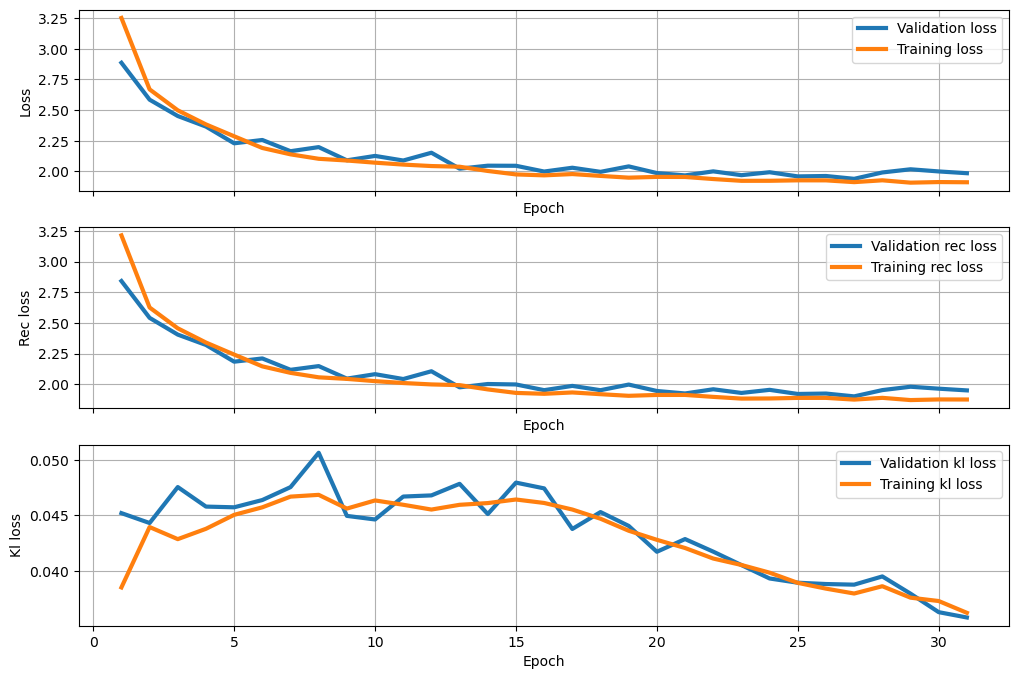

In [40]:
plot_history(hist[1:])

In [41]:
torch.save((model.kwargs ,model.state_dict()), "models/final/sobel/vae.pt")

test_loss: 1.8702 - test_rec_loss: 1.8340 - test_kl_loss: 0.0361


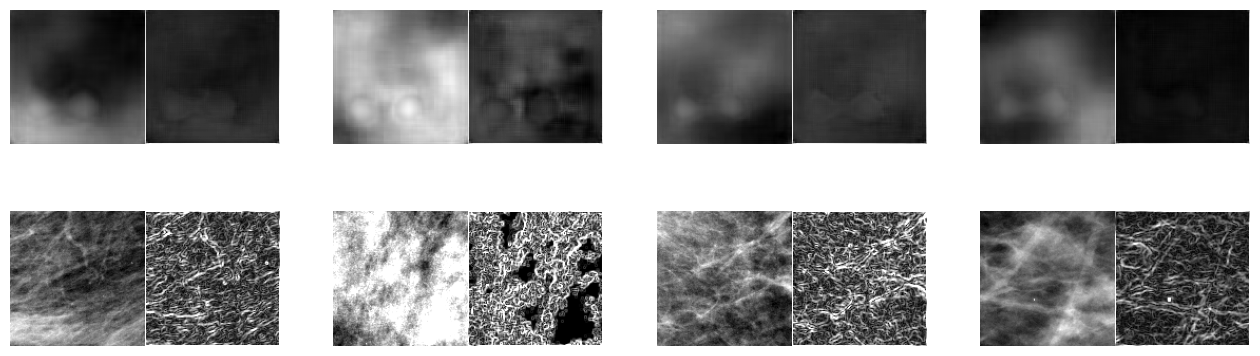

In [42]:
test_metrics = validate(model, dataloaders['test'], kl_reconstruction_loss)

print(get_metrics_str(test_metrics, 'test_'))

plot_reconstructions(model, dataloaders['test'], plot_borders=True)

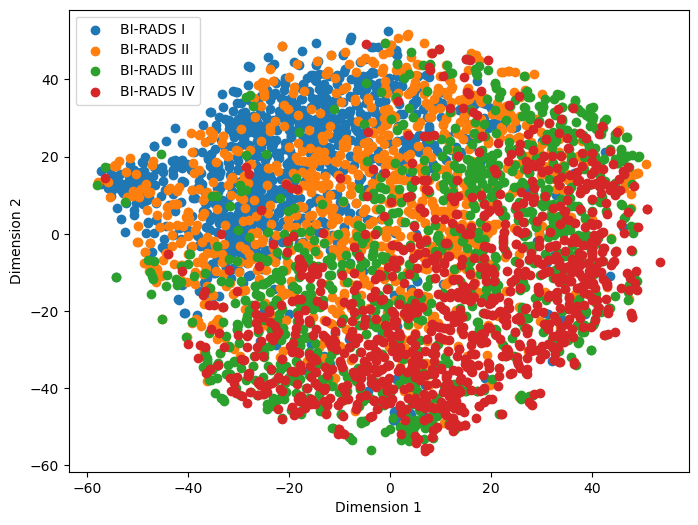

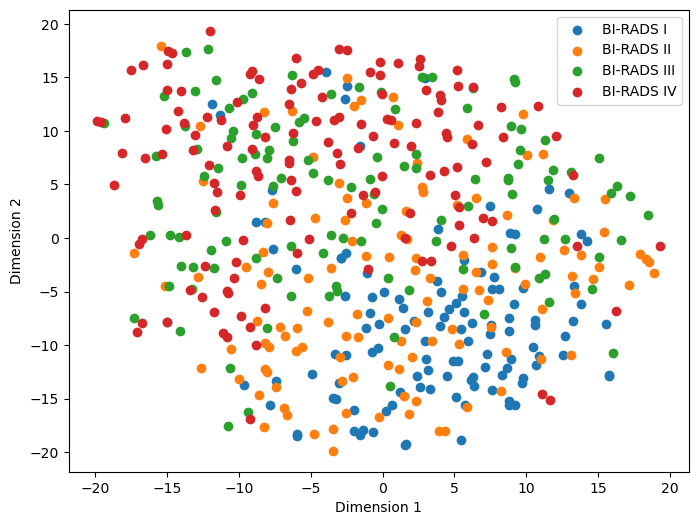

In [43]:
train_latent, train_labels = get_latent(model, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(model, dataloaders["test"], IrmaDataset.get_class_label)

tsne = TSNE()
train_tsne_latent = tsne.fit_transform(train_latent, train_labels)
tsne_latent = tsne.fit_transform(latent)

plot_2d(train_tsne_latent, train_labels, 'tab10', IrmaDataset.get_class_label_value)
plot_2d(tsne_latent, labels, 'tab10', IrmaDataset.get_class_label_value)

In [44]:
train_latent, train_labels = get_latent(model, dataloaders["train"])
val_latent, val_labels = get_latent(model, dataloaders["val"])
latent, labels = get_latent(model, dataloaders["test"])

In [45]:
train_latent, train_labels = train_latent.astype('float32'), train_labels.astype('int64')
val_latent, val_labels = val_latent.astype('float32'), val_labels.astype('int64')
latent, labels = latent.astype('float32'), labels.astype('int64')

In [46]:
train_ds = TensorDataset(torch.tensor(train_latent), torch.tensor(train_labels))
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

val_ds = TensorDataset(torch.tensor(val_latent), torch.tensor(val_labels))
val_dl = DataLoader(val_ds, batch_size)

test_ds = TensorDataset(torch.tensor(latent), torch.tensor(labels))
test_dl = DataLoader(test_ds, batch_size)

In [47]:
pred_model = torch.nn.Sequential(
    torch.nn.Linear(64, 128),
    torch.nn.GELU(),
    torch.nn.Linear(128, 256),
    torch.nn.GELU(),
    torch.nn.Linear(256, 128),
    torch.nn.GELU(),
    torch.nn.Linear(128, 64),
    torch.nn.GELU(),
    torch.nn.Linear(64, 4),
    torch.nn.Softmax(-1)
)

summary(pred_model, (32, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 4]                   --
├─Linear: 1-1                            [32, 128]                 8,320
├─GELU: 1-2                              [32, 128]                 --
├─Linear: 1-3                            [32, 256]                 33,024
├─GELU: 1-4                              [32, 256]                 --
├─Linear: 1-5                            [32, 128]                 32,896
├─GELU: 1-6                              [32, 128]                 --
├─Linear: 1-7                            [32, 64]                  8,256
├─GELU: 1-8                              [32, 64]                  --
├─Linear: 1-9                            [32, 4]                   260
├─Softmax: 1-10                          [32, 4]                   --
Total params: 82,756
Trainable params: 82,756
Non-trainable params: 0
Total mult-adds (M): 2.65
Input size (MB): 0.01
Forward/backward pass 

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(pred_model.parameters(), lr=0.00002)
pred_model.to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

hist = train(pred_model, optimizer, train_dl, val_dl, 64, pred_loss)

[epoch: 1] train_loss: 1.3860 - train_predict_loss: 1.3860 - train_accuracy: 0.2486 - val_loss: 1.3844 - val_predict_loss: 1.3844 - val_accuracy: 0.2406
[epoch: 2] train_loss: 1.3838 - train_predict_loss: 1.3838 - train_accuracy: 0.2715 - val_loss: 1.3811 - val_predict_loss: 1.3811 - val_accuracy: 0.3062
[epoch: 3] train_loss: 1.3771 - train_predict_loss: 1.3771 - train_accuracy: 0.3313 - val_loss: 1.3692 - val_predict_loss: 1.3692 - val_accuracy: 0.3519
[epoch: 4] train_loss: 1.3531 - train_predict_loss: 1.3531 - train_accuracy: 0.4094 - val_loss: 1.3302 - val_predict_loss: 1.3302 - val_accuracy: 0.4294
[epoch: 5] train_loss: 1.3004 - train_predict_loss: 1.3004 - train_accuracy: 0.4659 - val_loss: 1.2730 - val_predict_loss: 1.2730 - val_accuracy: 0.4612
[epoch: 6] train_loss: 1.2495 - train_predict_loss: 1.2495 - train_accuracy: 0.4637 - val_loss: 1.2437 - val_predict_loss: 1.2437 - val_accuracy: 0.4553
[epoch: 7] train_loss: 1.2295 - train_predict_loss: 1.2295 - train_accuracy: 0.466

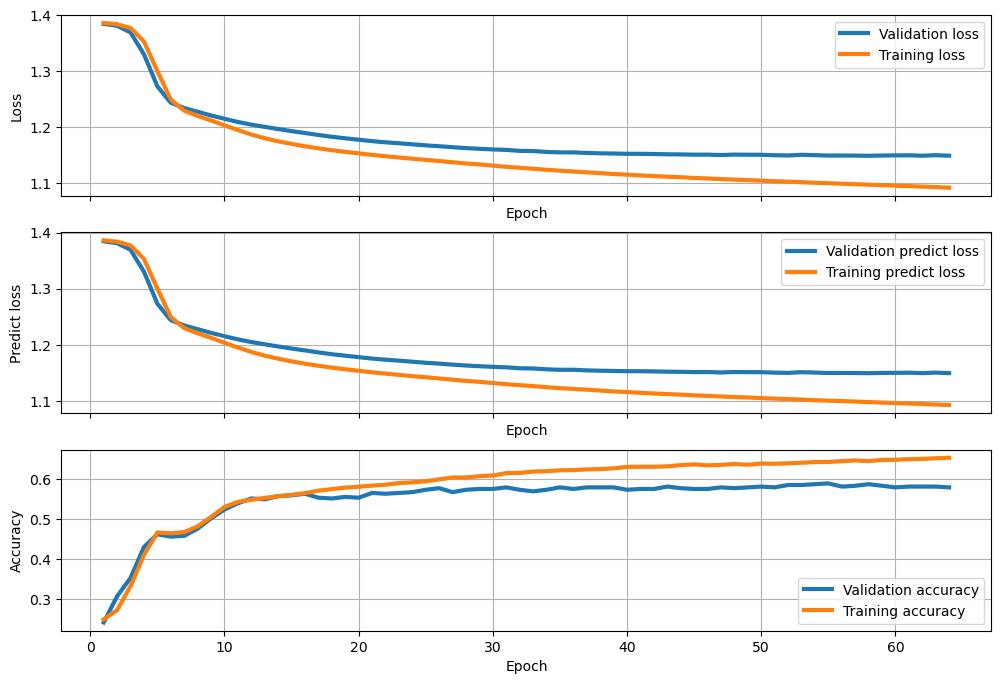

In [49]:
plot_history(hist)

In [50]:
test_metrics = validate(pred_model, test_dl, pred_loss)

print(get_metrics_str(test_metrics, 'test_'))

test_loss: 1.1628 - test_predict_loss: 1.1628 - test_accuracy: 0.5626


In [51]:
y_pred, y_true = predict(pred_model, test_dl, return_class=True)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.69      0.69       121
           1       0.55      0.47      0.50       124
           2       0.44      0.43      0.43       119
           3       0.57      0.65      0.61       139

    accuracy                           0.56       503
   macro avg       0.56      0.56      0.56       503
weighted avg       0.56      0.56      0.56       503



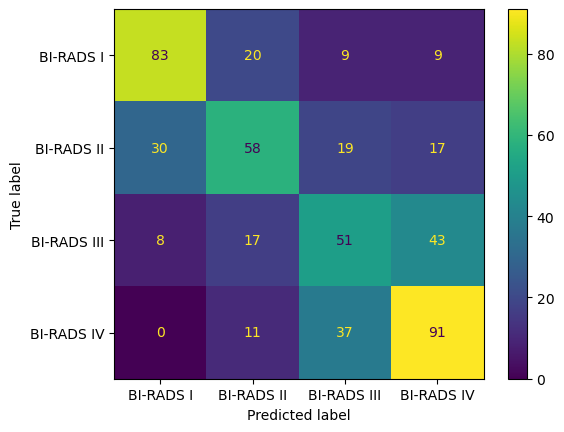

In [52]:
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=IrmaDataset.irma_classmap.classes_
)
cm_display.plot()

## PVAE

In [277]:
model = PVAE(
    latent_dim=64,
    n_channels=2,
    n_classes=4,
    conv_layers=[(5, 192), (3, 128), (3, 96), (3, 64)],
    conv_pooling=[2, 2, 2, 2],
    linear_input=(64, 6, 6),
    linear_layers=[256, 128, 64],
    pred_layers=[128, 64],
    clamp_output=False,
    use_batchnorm=False
)
summary(model, input_size=(32, 2, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
PVAE                                     [32, 2, 128, 128]         --
├─Encoder: 1-1                           [32, 64]                  --
│    └─Sequential: 2-1                   [32, 64, 6, 6]            --
│    │    └─Conv2d: 3-1                  [32, 192, 124, 124]       9,792
│    │    └─GELU: 3-2                    [32, 192, 124, 124]       --
│    │    └─MaxPool2d: 3-3               [32, 192, 62, 62]         --
│    │    └─Conv2d: 3-4                  [32, 128, 60, 60]         221,312
│    │    └─GELU: 3-5                    [32, 128, 60, 60]         --
│    │    └─MaxPool2d: 3-6               [32, 128, 30, 30]         --
│    │    └─Conv2d: 3-7                  [32, 96, 28, 28]          110,688
│    │    └─GELU: 3-8                    [32, 96, 28, 28]          --
│    │    └─MaxPool2d: 3-9               [32, 96, 14, 14]          --
│    │    └─Conv2d: 3-10                 [32, 64, 12, 12]          55,36

In [278]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(model.parameters())
model.to(device)

hist = train(model, optimizer, dataloaders['train'], dataloaders['val'], 32, pred_kl_reconstruction_loss)

[epoch: 1] train_loss: 6.9732 - train_rec_loss: 5.6527 - train_kl_loss: 0.0199 - train_pred_loss: 1.3005 - train_accuracy: 0.3766 - val_loss: 5.0315 - val_rec_loss: 3.7695 - val_kl_loss: 0.0306 - val_pred_loss: 1.2315 - val_accuracy: 0.4712
[epoch: 2] train_loss: 4.1378 - train_rec_loss: 2.9141 - train_kl_loss: 0.0398 - train_pred_loss: 1.1839 - train_accuracy: 0.5393 - val_loss: 3.9049 - val_rec_loss: 2.6919 - val_kl_loss: 0.0393 - val_pred_loss: 1.1737 - val_accuracy: 0.5626
[epoch: 3] train_loss: 3.6322 - train_rec_loss: 2.4454 - train_kl_loss: 0.0411 - train_pred_loss: 1.1456 - train_accuracy: 0.5839 - val_loss: 3.5964 - val_rec_loss: 2.3993 - val_kl_loss: 0.0456 - val_pred_loss: 1.1515 - val_accuracy: 0.5885
[epoch: 4] train_loss: 3.5134 - train_rec_loss: 2.3565 - train_kl_loss: 0.0413 - train_pred_loss: 1.1156 - train_accuracy: 0.6222 - val_loss: 3.4967 - val_rec_loss: 2.3238 - val_kl_loss: 0.0452 - val_pred_loss: 1.1277 - val_accuracy: 0.6183
[epoch: 5] train_loss: 3.4499 - trai

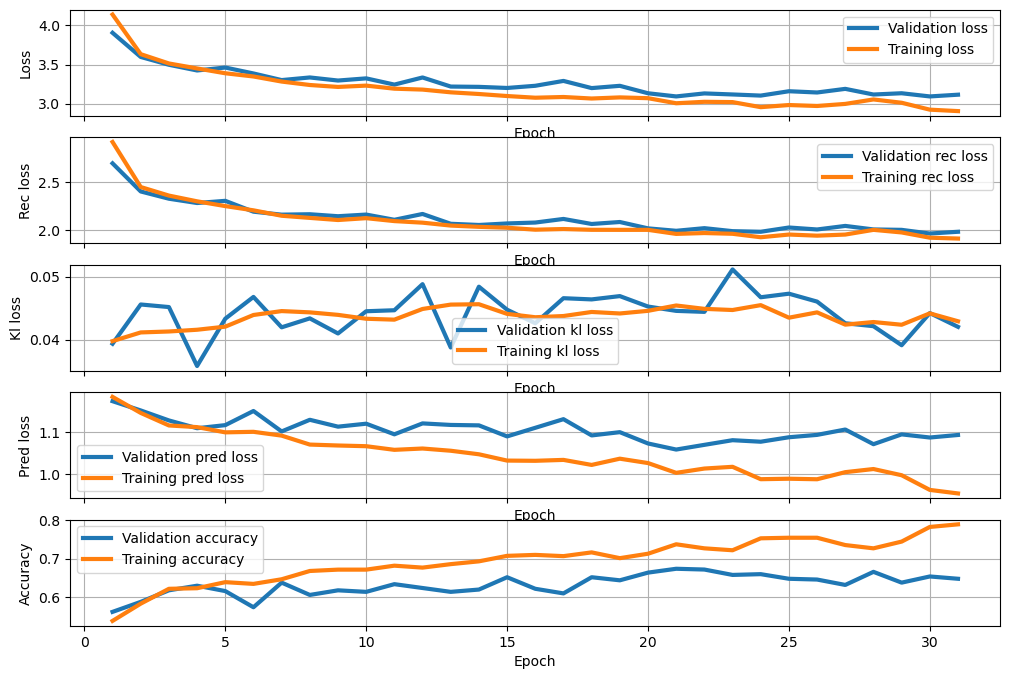

In [279]:
plot_history(hist[1:])

In [56]:
torch.save((model.kwargs ,model.state_dict()), "models/final/sobel/pvae.pt")

test_loss: 3.0716 - test_rec_loss: 1.9055 - test_kl_loss: 0.0430 - test_pred_loss: 1.1232 - test_accuracy: 0.6163


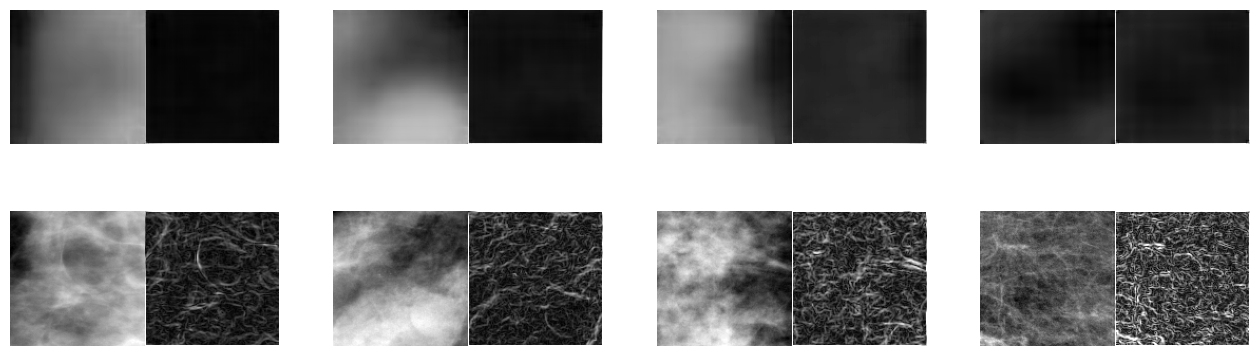

In [280]:
test_metrics = validate(model, dataloaders['test'], pred_kl_reconstruction_loss)

print(get_metrics_str(test_metrics, 'test_'))

plot_reconstructions(model, dataloaders['test'], plot_borders=True)

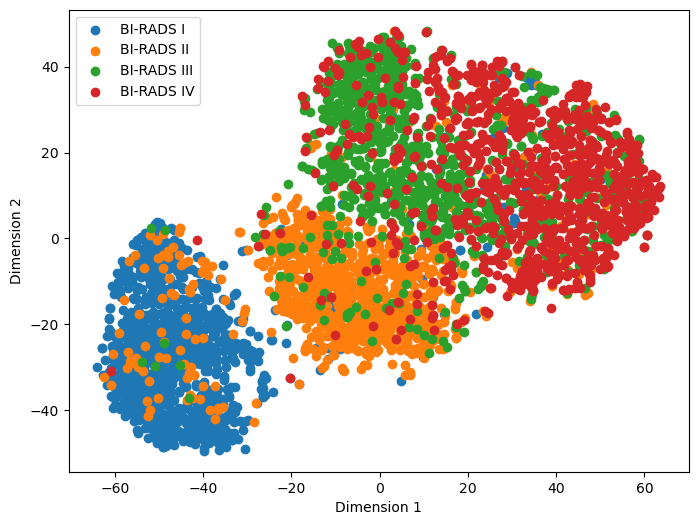

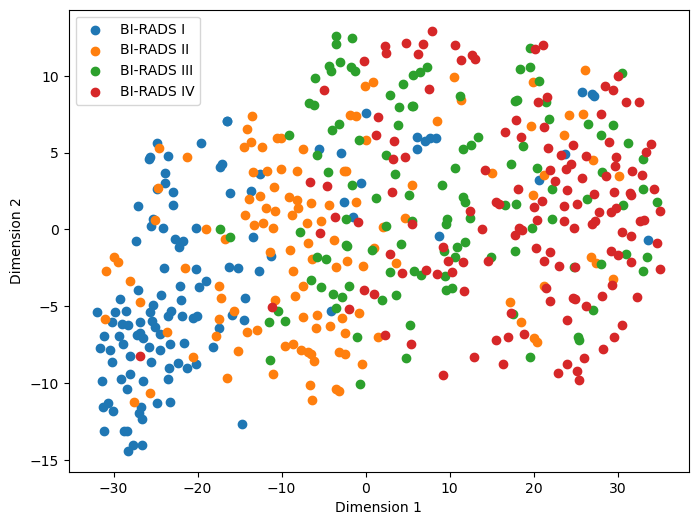

In [281]:
train_latent, train_labels = get_latent(model, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(model, dataloaders["test"], IrmaDataset.get_class_label)

tsne = TSNE()
train_tsne_latent = tsne.fit_transform(train_latent, train_labels)
tsne_latent = tsne.fit_transform(latent)

plot_2d(train_tsne_latent, train_labels, 'tab10', IrmaDataset.get_class_label_value)
plot_2d(tsne_latent, labels, 'tab10', IrmaDataset.get_class_label_value)

In [282]:
train_latent, train_labels = get_latent(model, dataloaders["train"])
val_latent, val_labels = get_latent(model, dataloaders["val"])
latent, labels = get_latent(model, dataloaders["test"])

In [283]:
train_latent, train_labels = train_latent.astype('float32'), train_labels.astype('int64')
val_latent, val_labels = val_latent.astype('float32'), val_labels.astype('int64')
latent, labels = latent.astype('float32'), labels.astype('int64')

In [284]:
train_ds = TensorDataset(torch.tensor(train_latent), torch.tensor(train_labels))
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

val_ds = TensorDataset(torch.tensor(val_latent), torch.tensor(val_labels))
val_dl = DataLoader(val_ds, batch_size)

test_ds = TensorDataset(torch.tensor(latent), torch.tensor(labels))
test_dl = DataLoader(test_ds, batch_size)

In [285]:
pred_model = torch.nn.Sequential(
    torch.nn.Linear(64, 128),
    torch.nn.GELU(),
    torch.nn.Linear(128, 256),
    torch.nn.GELU(),
    torch.nn.Linear(256, 128),
    torch.nn.GELU(),
    torch.nn.Linear(128, 64),
    torch.nn.GELU(),
    torch.nn.Linear(64, 4),
    torch.nn.Softmax(-1)
)

summary(pred_model, (32, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 4]                   --
├─Linear: 1-1                            [32, 128]                 8,320
├─GELU: 1-2                              [32, 128]                 --
├─Linear: 1-3                            [32, 256]                 33,024
├─GELU: 1-4                              [32, 256]                 --
├─Linear: 1-5                            [32, 128]                 32,896
├─GELU: 1-6                              [32, 128]                 --
├─Linear: 1-7                            [32, 64]                  8,256
├─GELU: 1-8                              [32, 64]                  --
├─Linear: 1-9                            [32, 4]                   260
├─Softmax: 1-10                          [32, 4]                   --
Total params: 82,756
Trainable params: 82,756
Non-trainable params: 0
Total mult-adds (M): 2.65
Input size (MB): 0.01
Forward/backward pass 

In [286]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(pred_model.parameters(), lr=0.00002)
pred_model.to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

hist = train(pred_model, optimizer, train_dl, val_dl, 64, pred_loss)

[epoch: 1] train_loss: 1.3836 - train_predict_loss: 1.3836 - train_accuracy: 0.2708 - val_loss: 1.3822 - val_predict_loss: 1.3822 - val_accuracy: 0.3897
[epoch: 2] train_loss: 1.3734 - train_predict_loss: 1.3734 - train_accuracy: 0.4686 - val_loss: 1.3651 - val_predict_loss: 1.3651 - val_accuracy: 0.4771
[epoch: 3] train_loss: 1.3251 - train_predict_loss: 1.3251 - train_accuracy: 0.5261 - val_loss: 1.2810 - val_predict_loss: 1.2810 - val_accuracy: 0.4891
[epoch: 4] train_loss: 1.2171 - train_predict_loss: 1.2171 - train_accuracy: 0.5550 - val_loss: 1.2157 - val_predict_loss: 1.2157 - val_accuracy: 0.5089
[epoch: 5] train_loss: 1.1629 - train_predict_loss: 1.1629 - train_accuracy: 0.5839 - val_loss: 1.1932 - val_predict_loss: 1.1932 - val_accuracy: 0.5308
[epoch: 6] train_loss: 1.1262 - train_predict_loss: 1.1262 - train_accuracy: 0.6177 - val_loss: 1.1760 - val_predict_loss: 1.1760 - val_accuracy: 0.5368
[epoch: 7] train_loss: 1.0951 - train_predict_loss: 1.0951 - train_accuracy: 0.641

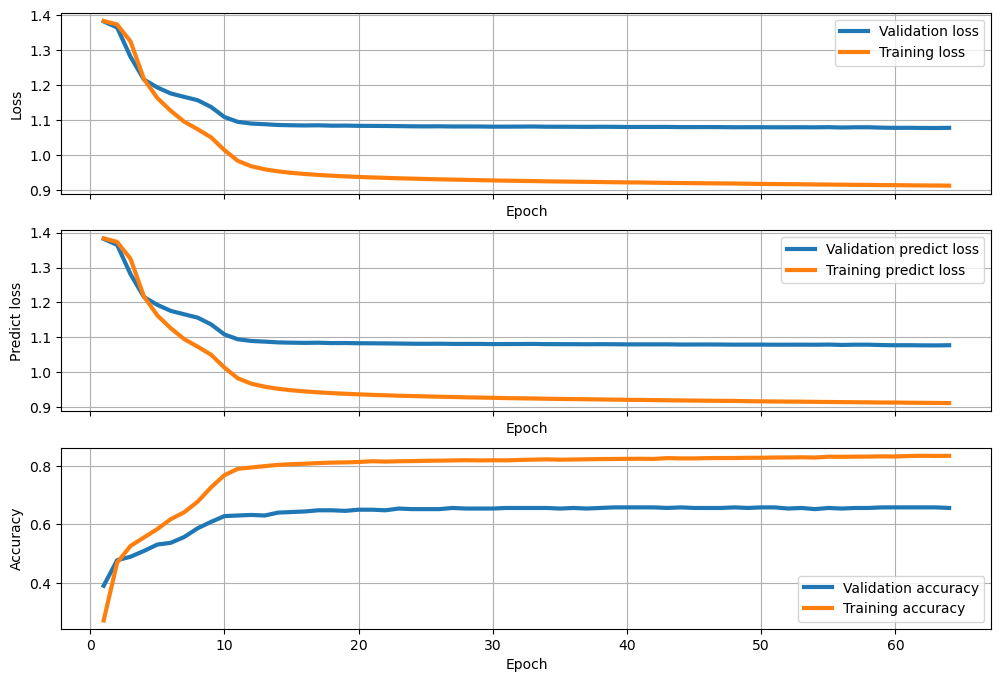

In [287]:
plot_history(hist)

In [288]:
test_metrics = validate(pred_model, test_dl, pred_loss)

print(get_metrics_str(test_metrics, 'test_'))

test_loss: 1.1129 - test_predict_loss: 1.1129 - test_accuracy: 0.6282


In [289]:
y_pred, y_true = predict(pred_model, test_dl, return_class=True)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.74      0.80       121
           1       0.60      0.65      0.62       124
           2       0.52      0.47      0.50       119
           3       0.57      0.64      0.60       139

    accuracy                           0.63       503
   macro avg       0.64      0.63      0.63       503
weighted avg       0.64      0.63      0.63       503



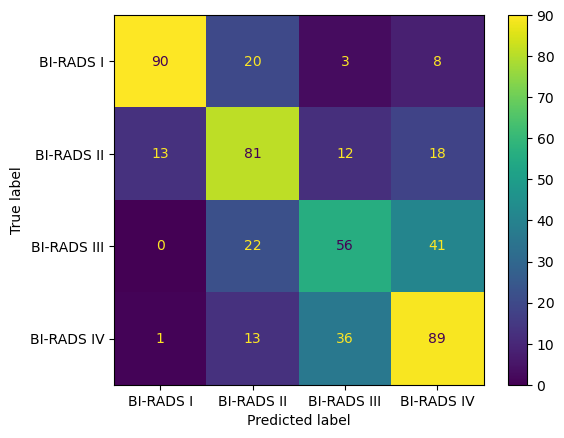

In [290]:
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=IrmaDataset.irma_classmap.classes_
)
cm_display.plot()

# Laplacian Dataset

In [20]:
def countTriplets(arr: list[int]) -> int:
    n = 0

    for i in range(len(arr) - 1):
        a = arr[i]
        for j in range(i + 1, len(arr)):
            b = arr[j]
            for k in range(j, len(arr)):
                if j != k:
                    b ^= arr[k]
                if a == b:
                    n +=1
                
            a ^= arr[j]

    return n

countTriplets([2,3,1,6,7])

(0, 1, 1), (2, 3)
(0, 1, 2), (2, 2)
(0, 1, 3), (2, 4)
(0, 1, 4), (2, 3)
(0, 2, 2), (1, 1)
(0, 2, 3), (1, 7)
(0, 2, 4), (1, 0)
(0, 3, 3), (0, 6)
(0, 3, 4), (0, 1)
(0, 4, 4), (6, 7)
(1, 2, 2), (3, 1)
(1, 2, 3), (3, 7)
(1, 2, 4), (3, 0)
(1, 3, 3), (2, 6)
(1, 3, 4), (2, 1)
(1, 4, 4), (4, 7)
(2, 3, 3), (1, 6)
(2, 3, 4), (1, 1)
(2, 4, 4), (7, 7)
(3, 4, 4), (6, 7)


4

In [94]:
import re

m_regex = '([*/])? *(\d+) *'
regex = f' *([+-])? *( *\d+ *[*/]? *\d* *)*'
# print(regex)
s = "2*2*2"
res = 0

exps = re.findall(regex, s)
print(exps)
for j, exp in enumerate(re.findall(regex, s)):
    op, e = exp
    if len(e) == 0: break

    subres = None
    for subexp in re.findall(m_regex, e):
        o, n = subexp
        n = int(n)

        if o == '':
            subres = n
        elif o == '*':
            subres *= n
        elif o == '/':
            subres //= n
    
    if op == '':
        res = subres
    elif op == '+':
        res += subres
    elif op == '-':
        res -= subres
    print(res)

# stack
res
# resolveStack(stack)

[('', ''), ('', '2*'), ('', ''), ('', '2*'), ('', ''), ('', '2'), ('', '')]


0

In [17]:
'abcdefghijkl'[:5:-1]

'lkjihg'

In [31]:
m.span()

(0, 3)

In [10]:
dataset = IrmaDataset(
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            MinMaxScaler(),
            Laplacian(),
            MinMaxScaler()
        ]
    ),
    return_images=True,
)

datasets = train_val_split(dataset, 0.1, random_state=7)
datasets['test'] = datasets['val']
datasets = {**datasets, **train_val_split(datasets['train'], 0.1 / 0.9, random_state=7)}

dataloaders = {
    x: DataLoader(datasets[x], batch_size, shuffle=True)
    for x in ['train', 'test', 'val']
}

len(datasets['train']), len(datasets['test']), len(datasets['val'])

(4018, 503, 503)

In [48]:
import math
x = 1001
N = int(math.log(x, 10) +1)
for i in range(N // 2):
    ci = N - i - 1

    big =  (x // 10 ** ci - x // 10 ** (ci + 1) * 10) % 10
    small =  (x % 10 ** (i+1) * 10 - x % 10 ** (i)) % 10

    if big != small: 
        print(x % 10 ** (i+1), x % 10 ** (i) * 10)
        print(f'{big}, {small}')    
        break

1 0
1, 0


In [50]:
'asdasd'[-1::-1]

'dsadsa'

In [11]:
ex_images.append(get_sample_images(datasets['test']))

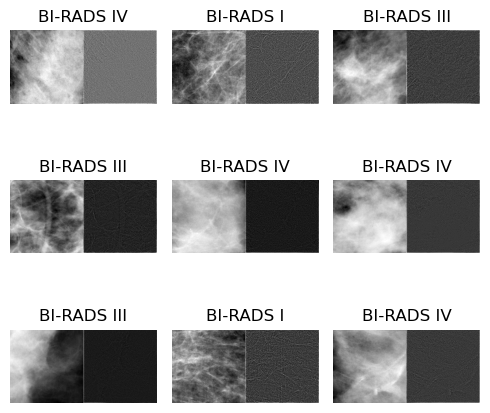

In [69]:
sample_images(dataloaders['train'], label_mapper=IrmaDataset.get_class_label, plot_borders=True)

## VAE

In [70]:
model = VAE(
    latent_dim=64,
    n_channels=2,
    conv_layers=[(5, 192), (3, 128), (3, 96), (3, 64)],
    conv_pooling=[2, 2, 2, 2],
    linear_input=(64, 6, 6),
    linear_layers=[256, 128, 64],
    clamp_output=False,
    use_batchnorm=True
)
summary(model, input_size=(32, 2, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [32, 2, 128, 128]         --
├─Encoder: 1-1                           [32, 64]                  --
│    └─Sequential: 2-1                   [32, 64, 6, 6]            --
│    │    └─Conv2d: 3-1                  [32, 192, 124, 124]       9,792
│    │    └─BatchNorm2d: 3-2             [32, 192, 124, 124]       384
│    │    └─GELU: 3-3                    [32, 192, 124, 124]       --
│    │    └─MaxPool2d: 3-4               [32, 192, 62, 62]         --
│    │    └─Conv2d: 3-5                  [32, 128, 60, 60]         221,312
│    │    └─BatchNorm2d: 3-6             [32, 128, 60, 60]         256
│    │    └─GELU: 3-7                    [32, 128, 60, 60]         --
│    │    └─MaxPool2d: 3-8               [32, 128, 30, 30]         --
│    │    └─Conv2d: 3-9                  [32, 96, 28, 28]          110,688
│    │    └─BatchNorm2d: 3-10            [32, 96, 28, 28]          192

In [71]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(model.parameters())
model.to(device)

hist = train(model, optimizer, dataloaders['train'], dataloaders['val'], 32, kl_reconstruction_loss)

[epoch: 1] train_loss: 9.7311 - train_rec_loss: 9.6768 - train_kl_loss: 0.0544 - val_loss: 2.7284 - val_rec_loss: 2.6907 - val_kl_loss: 0.0378
[epoch: 2] train_loss: 2.3705 - train_rec_loss: 2.3345 - train_kl_loss: 0.0361 - val_loss: 2.2971 - val_rec_loss: 2.2639 - val_kl_loss: 0.0332
[epoch: 3] train_loss: 1.9912 - train_rec_loss: 1.9521 - train_kl_loss: 0.0390 - val_loss: 1.8754 - val_rec_loss: 1.8318 - val_kl_loss: 0.0436
[epoch: 4] train_loss: 1.6628 - train_rec_loss: 1.6163 - train_kl_loss: 0.0465 - val_loss: 1.5870 - val_rec_loss: 1.5321 - val_kl_loss: 0.0549
[epoch: 5] train_loss: 1.4345 - train_rec_loss: 1.3831 - train_kl_loss: 0.0514 - val_loss: 1.3587 - val_rec_loss: 1.3091 - val_kl_loss: 0.0496
[epoch: 6] train_loss: 1.3493 - train_rec_loss: 1.3008 - train_kl_loss: 0.0485 - val_loss: 1.3065 - val_rec_loss: 1.2590 - val_kl_loss: 0.0476
[epoch: 7] train_loss: 1.2483 - train_rec_loss: 1.1993 - train_kl_loss: 0.0490 - val_loss: 1.2157 - val_rec_loss: 1.1652 - val_kl_loss: 0.0505

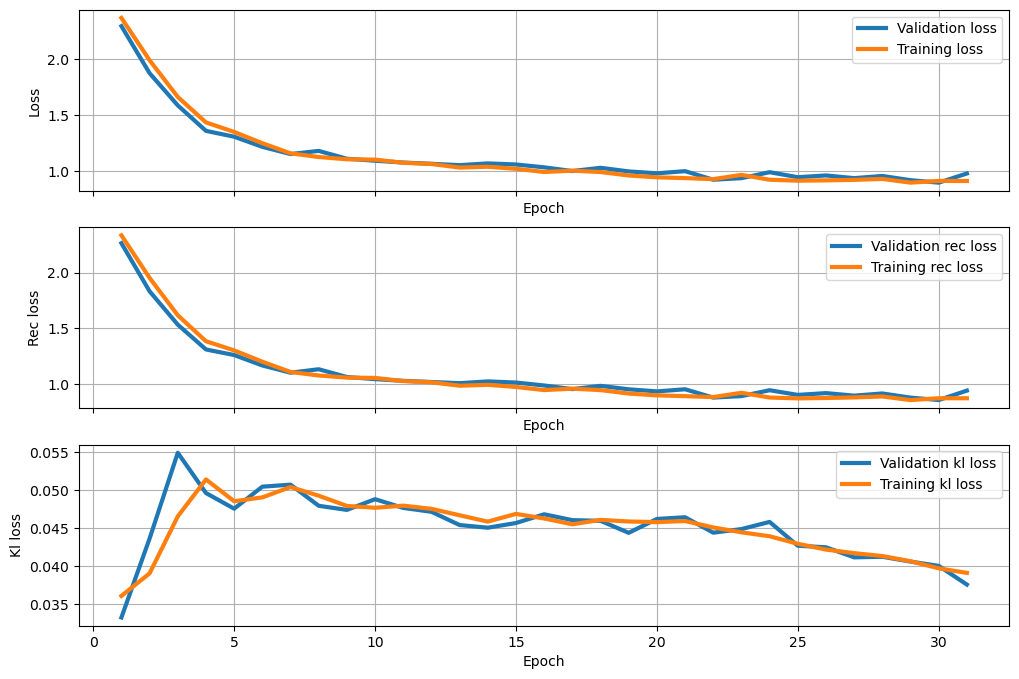

In [72]:
plot_history(hist[1:])

In [73]:
torch.save((model.kwargs ,model.state_dict()), "models/final/laplacian/vae.pt")

test_loss: 0.9748 - test_rec_loss: 0.9359 - test_kl_loss: 0.0389


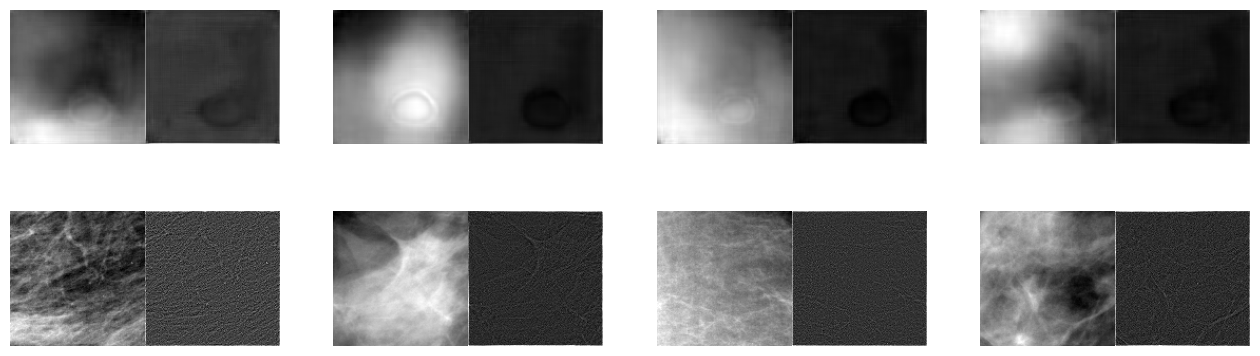

In [74]:
test_metrics = validate(model, dataloaders['test'], kl_reconstruction_loss)

print(get_metrics_str(test_metrics, 'test_'))

plot_reconstructions(model, dataloaders['test'], plot_borders=True)

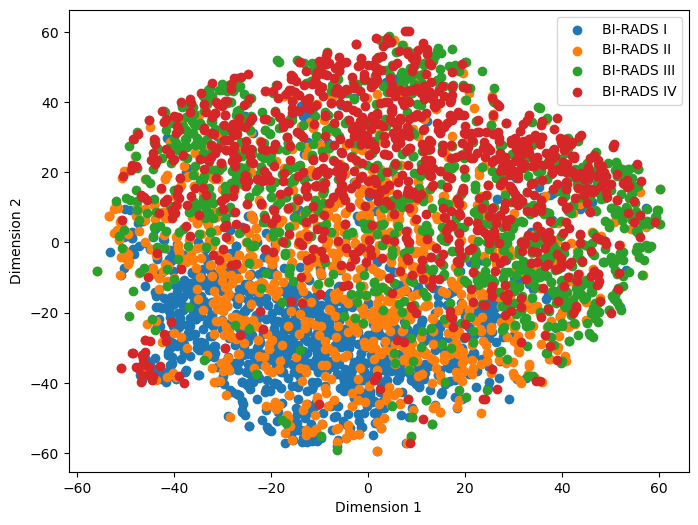

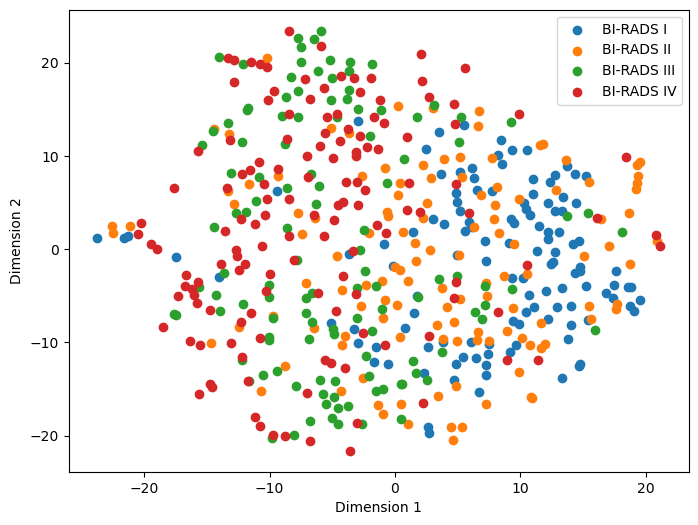

In [75]:
train_latent, train_labels = get_latent(model, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(model, dataloaders["test"], IrmaDataset.get_class_label)

tsne = TSNE()
train_tsne_latent = tsne.fit_transform(train_latent, train_labels)
tsne_latent = tsne.fit_transform(latent)

plot_2d(train_tsne_latent, train_labels, 'tab10', IrmaDataset.get_class_label_value)
plot_2d(tsne_latent, labels, 'tab10', IrmaDataset.get_class_label_value)

In [76]:
train_latent, train_labels = get_latent(model, dataloaders["train"])
val_latent, val_labels = get_latent(model, dataloaders["val"])
latent, labels = get_latent(model, dataloaders["test"])

In [77]:
train_latent, train_labels = train_latent.astype('float32'), train_labels.astype('int64')
val_latent, val_labels = val_latent.astype('float32'), val_labels.astype('int64')
latent, labels = latent.astype('float32'), labels.astype('int64')

In [78]:
train_ds = TensorDataset(torch.tensor(train_latent), torch.tensor(train_labels))
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

val_ds = TensorDataset(torch.tensor(val_latent), torch.tensor(val_labels))
val_dl = DataLoader(val_ds, batch_size)

test_ds = TensorDataset(torch.tensor(latent), torch.tensor(labels))
test_dl = DataLoader(test_ds, batch_size)

In [79]:
pred_model = torch.nn.Sequential(
    torch.nn.Linear(64, 128),
    torch.nn.GELU(),
    torch.nn.Linear(128, 256),
    torch.nn.GELU(),
    torch.nn.Linear(256, 128),
    torch.nn.GELU(),
    torch.nn.Linear(128, 64),
    torch.nn.GELU(),
    torch.nn.Linear(64, 4),
    torch.nn.Softmax(-1)
)

summary(pred_model, (32, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 4]                   --
├─Linear: 1-1                            [32, 128]                 8,320
├─GELU: 1-2                              [32, 128]                 --
├─Linear: 1-3                            [32, 256]                 33,024
├─GELU: 1-4                              [32, 256]                 --
├─Linear: 1-5                            [32, 128]                 32,896
├─GELU: 1-6                              [32, 128]                 --
├─Linear: 1-7                            [32, 64]                  8,256
├─GELU: 1-8                              [32, 64]                  --
├─Linear: 1-9                            [32, 4]                   260
├─Softmax: 1-10                          [32, 4]                   --
Total params: 82,756
Trainable params: 82,756
Non-trainable params: 0
Total mult-adds (M): 2.65
Input size (MB): 0.01
Forward/backward pass 

In [80]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(pred_model.parameters(), lr=0.00002)
pred_model.to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

hist = train(pred_model, optimizer, train_dl, val_dl, 64, pred_loss)

[epoch: 1] train_loss: 1.3857 - train_predict_loss: 1.3857 - train_accuracy: 0.2466 - val_loss: 1.3839 - val_predict_loss: 1.3839 - val_accuracy: 0.2803
[epoch: 2] train_loss: 1.3828 - train_predict_loss: 1.3828 - train_accuracy: 0.2509 - val_loss: 1.3791 - val_predict_loss: 1.3791 - val_accuracy: 0.2903
[epoch: 3] train_loss: 1.3728 - train_predict_loss: 1.3728 - train_accuracy: 0.3992 - val_loss: 1.3600 - val_predict_loss: 1.3600 - val_accuracy: 0.5368
[epoch: 4] train_loss: 1.3352 - train_predict_loss: 1.3352 - train_accuracy: 0.4993 - val_loss: 1.3019 - val_predict_loss: 1.3019 - val_accuracy: 0.4652
[epoch: 5] train_loss: 1.2754 - train_predict_loss: 1.2754 - train_accuracy: 0.4679 - val_loss: 1.2566 - val_predict_loss: 1.2566 - val_accuracy: 0.4493
[epoch: 6] train_loss: 1.2476 - train_predict_loss: 1.2476 - train_accuracy: 0.4681 - val_loss: 1.2411 - val_predict_loss: 1.2411 - val_accuracy: 0.4573
[epoch: 7] train_loss: 1.2360 - train_predict_loss: 1.2360 - train_accuracy: 0.474

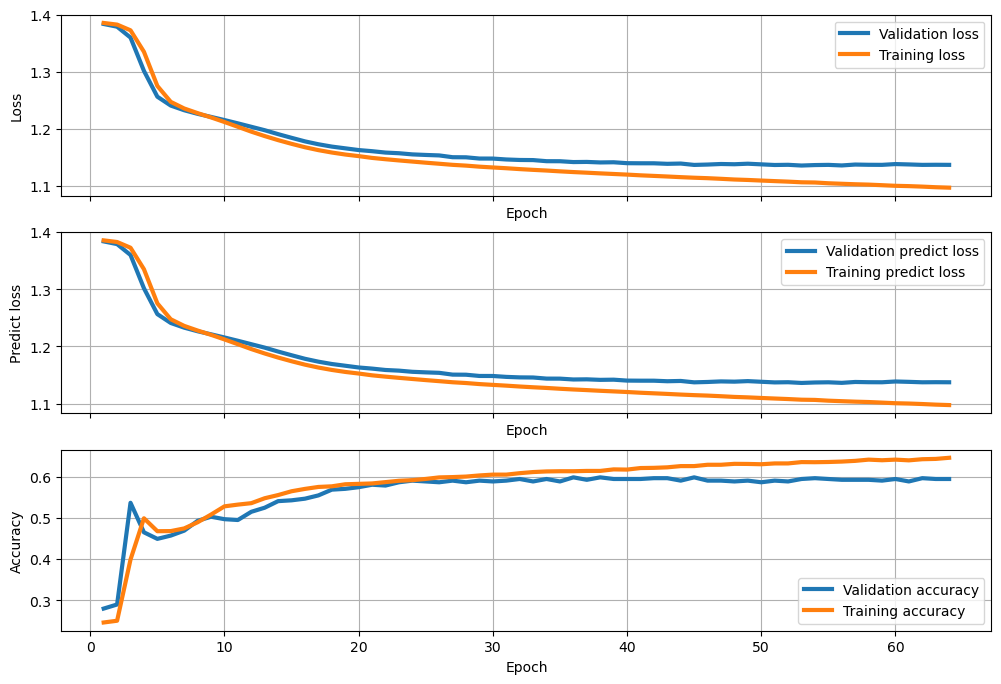

In [81]:
plot_history(hist)

In [82]:
test_metrics = validate(pred_model, test_dl, pred_loss)

print(get_metrics_str(test_metrics, 'test_'))

test_loss: 1.1218 - test_predict_loss: 1.1218 - test_accuracy: 0.6163


In [83]:
y_pred, y_true = predict(pred_model, test_dl, return_class=True)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75       121
           1       0.55      0.56      0.55       124
           2       0.55      0.55      0.55       119
           3       0.62      0.61      0.62       139

    accuracy                           0.62       503
   macro avg       0.62      0.62      0.62       503
weighted avg       0.62      0.62      0.62       503



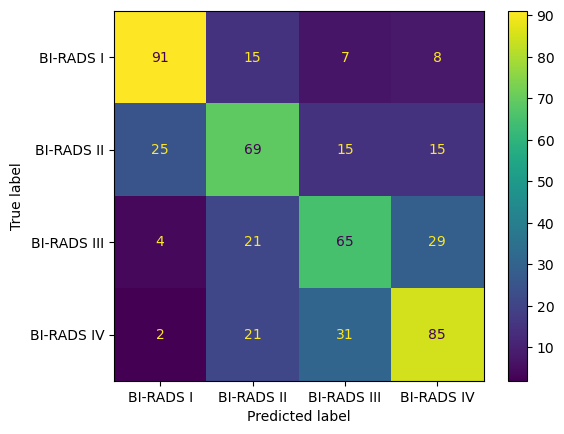

In [84]:
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=IrmaDataset.irma_classmap.classes_
)
cm_display.plot()

## PVAE

In [85]:
model = PVAE(
    latent_dim=64,
    n_channels=2,
    n_classes=4,
    conv_layers=[(5, 192), (3, 128), (3, 96), (3, 64)],
    conv_pooling=[2, 2, 2, 2],
    linear_input=(64, 6, 6),
    linear_layers=[256, 128, 64],
    pred_layers=[128, 64],
    clamp_output=False,
    use_batchnorm=True
)
summary(model, input_size=(32, 2, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
PVAE                                     [32, 2, 128, 128]         --
├─Encoder: 1-1                           [32, 64]                  --
│    └─Sequential: 2-1                   [32, 64, 6, 6]            --
│    │    └─Conv2d: 3-1                  [32, 192, 124, 124]       9,792
│    │    └─BatchNorm2d: 3-2             [32, 192, 124, 124]       384
│    │    └─GELU: 3-3                    [32, 192, 124, 124]       --
│    │    └─MaxPool2d: 3-4               [32, 192, 62, 62]         --
│    │    └─Conv2d: 3-5                  [32, 128, 60, 60]         221,312
│    │    └─BatchNorm2d: 3-6             [32, 128, 60, 60]         256
│    │    └─GELU: 3-7                    [32, 128, 60, 60]         --
│    │    └─MaxPool2d: 3-8               [32, 128, 30, 30]         --
│    │    └─Conv2d: 3-9                  [32, 96, 28, 28]          110,688
│    │    └─BatchNorm2d: 3-10            [32, 96, 28, 28]          192

In [86]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(model.parameters())
model.to(device)

hist = train(model, optimizer, dataloaders['train'], dataloaders['val'], 32, pred_kl_reconstruction_loss)

[epoch: 1] train_loss: 12.0749 - train_rec_loss: 10.7785 - train_kl_loss: 0.0172 - train_pred_loss: 1.2792 - train_accuracy: 0.4102 - val_loss: 4.0964 - val_rec_loss: 2.8464 - val_kl_loss: 0.0272 - val_pred_loss: 1.2228 - val_accuracy: 0.4712
[epoch: 2] train_loss: 3.4051 - train_rec_loss: 2.1731 - train_kl_loss: 0.0440 - train_pred_loss: 1.1880 - train_accuracy: 0.5406 - val_loss: 2.9431 - val_rec_loss: 1.7151 - val_kl_loss: 0.0510 - val_pred_loss: 1.1770 - val_accuracy: 0.5328
[epoch: 3] train_loss: 2.7857 - train_rec_loss: 1.5733 - train_kl_loss: 0.0478 - train_pred_loss: 1.1646 - train_accuracy: 0.5640 - val_loss: 2.7171 - val_rec_loss: 1.5141 - val_kl_loss: 0.0499 - val_pred_loss: 1.1531 - val_accuracy: 0.5865
[epoch: 4] train_loss: 2.6373 - train_rec_loss: 1.4541 - train_kl_loss: 0.0468 - train_pred_loss: 1.1363 - train_accuracy: 0.6013 - val_loss: 2.6298 - val_rec_loss: 1.4355 - val_kl_loss: 0.0485 - val_pred_loss: 1.1458 - val_accuracy: 0.5845
[epoch: 5] train_loss: 2.5481 - tr

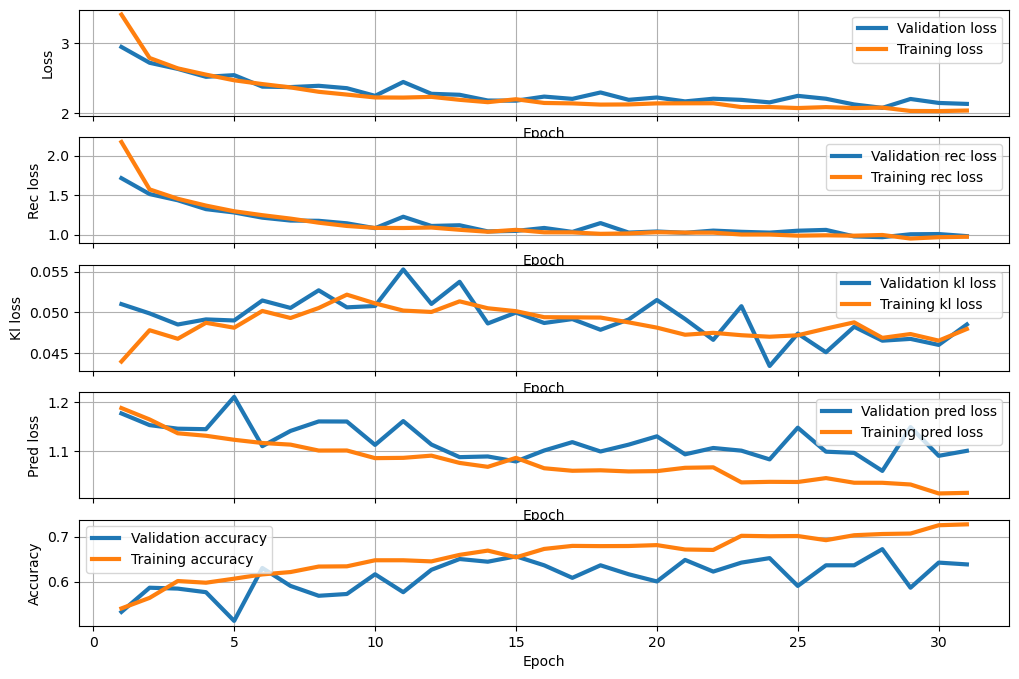

In [87]:
plot_history(hist[1:])

In [88]:
torch.save((model.kwargs ,model.state_dict()), "models/final/laplacian/pvae.pt")

test_loss: 2.1244 - test_rec_loss: 0.9563 - test_kl_loss: 0.0494 - test_pred_loss: 1.1186 - test_accuracy: 0.6163


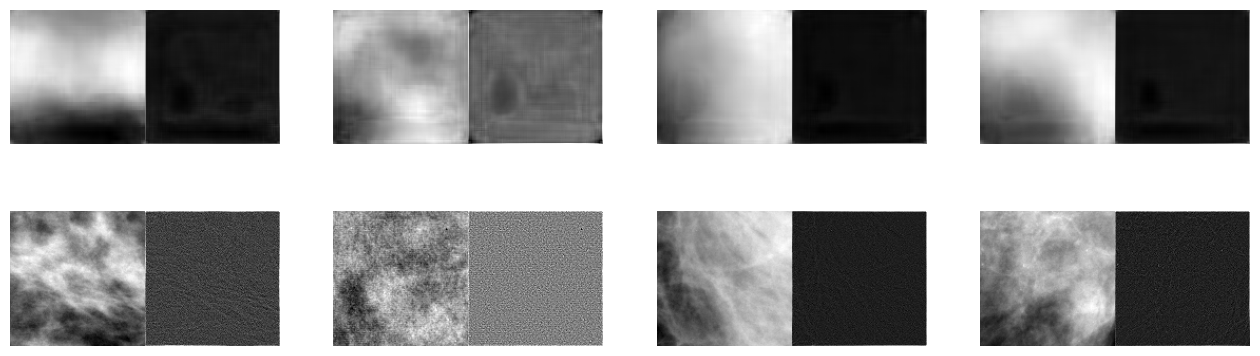

In [89]:
test_metrics = validate(model, dataloaders['test'], pred_kl_reconstruction_loss)

print(get_metrics_str(test_metrics, 'test_'))

plot_reconstructions(model, dataloaders['test'], plot_borders=True)

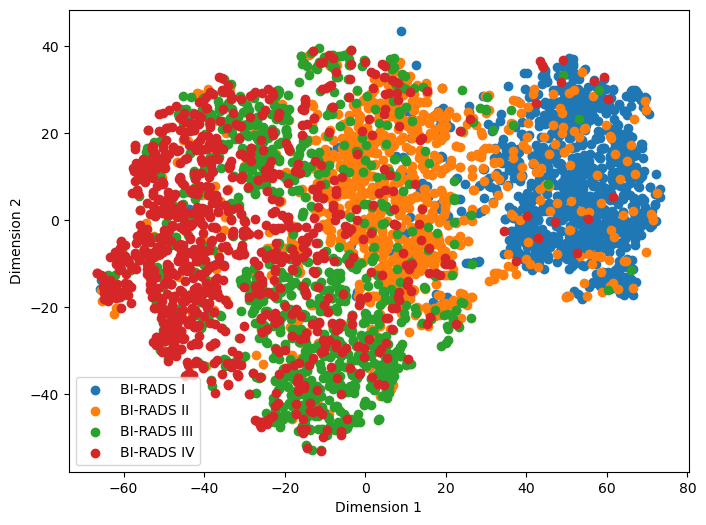

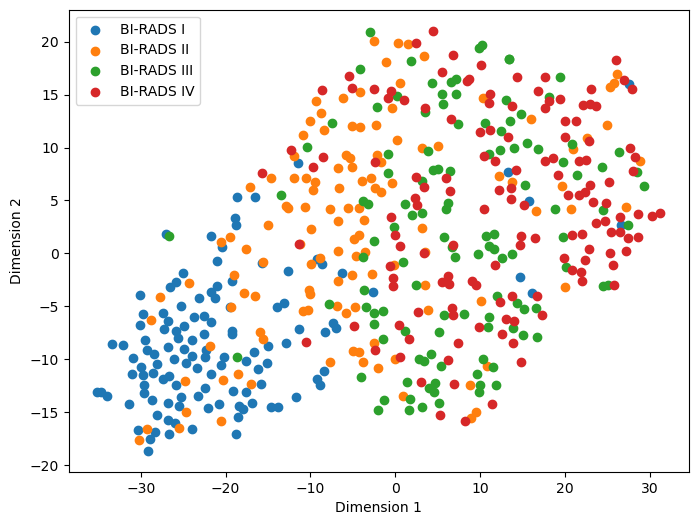

In [90]:
train_latent, train_labels = get_latent(model, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(model, dataloaders["test"], IrmaDataset.get_class_label)

tsne = TSNE()
train_tsne_latent = tsne.fit_transform(train_latent, train_labels)
tsne_latent = tsne.fit_transform(latent)

plot_2d(train_tsne_latent, train_labels, 'tab10', IrmaDataset.get_class_label_value)
plot_2d(tsne_latent, labels, 'tab10', IrmaDataset.get_class_label_value)

In [91]:
train_latent, train_labels = get_latent(model, dataloaders["train"])
val_latent, val_labels = get_latent(model, dataloaders["val"])
latent, labels = get_latent(model, dataloaders["test"])

In [92]:
train_latent, train_labels = train_latent.astype('float32'), train_labels.astype('int64')
val_latent, val_labels = val_latent.astype('float32'), val_labels.astype('int64')
latent, labels = latent.astype('float32'), labels.astype('int64')

In [93]:
train_ds = TensorDataset(torch.tensor(train_latent), torch.tensor(train_labels))
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

val_ds = TensorDataset(torch.tensor(val_latent), torch.tensor(val_labels))
val_dl = DataLoader(val_ds, batch_size)

test_ds = TensorDataset(torch.tensor(latent), torch.tensor(labels))
test_dl = DataLoader(test_ds, batch_size)

In [94]:
pred_model = torch.nn.Sequential(
    torch.nn.Linear(64, 128),
    torch.nn.GELU(),
    torch.nn.Linear(128, 256),
    torch.nn.GELU(),
    torch.nn.Linear(256, 128),
    torch.nn.GELU(),
    torch.nn.Linear(128, 64),
    torch.nn.GELU(),
    torch.nn.Linear(64, 4),
    torch.nn.Softmax(-1)
)

summary(pred_model, (32, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 4]                   --
├─Linear: 1-1                            [32, 128]                 8,320
├─GELU: 1-2                              [32, 128]                 --
├─Linear: 1-3                            [32, 256]                 33,024
├─GELU: 1-4                              [32, 256]                 --
├─Linear: 1-5                            [32, 128]                 32,896
├─GELU: 1-6                              [32, 128]                 --
├─Linear: 1-7                            [32, 64]                  8,256
├─GELU: 1-8                              [32, 64]                  --
├─Linear: 1-9                            [32, 4]                   260
├─Softmax: 1-10                          [32, 4]                   --
Total params: 82,756
Trainable params: 82,756
Non-trainable params: 0
Total mult-adds (M): 2.65
Input size (MB): 0.01
Forward/backward pass 

In [95]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(pred_model.parameters(), lr=0.00002)
pred_model.to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

hist = train(pred_model, optimizer, train_dl, val_dl, 64, pred_loss)

[epoch: 1] train_loss: 1.3839 - train_predict_loss: 1.3839 - train_accuracy: 0.3624 - val_loss: 1.3825 - val_predict_loss: 1.3825 - val_accuracy: 0.4732
[epoch: 2] train_loss: 1.3757 - train_predict_loss: 1.3757 - train_accuracy: 0.5719 - val_loss: 1.3690 - val_predict_loss: 1.3690 - val_accuracy: 0.5229
[epoch: 3] train_loss: 1.3414 - train_predict_loss: 1.3414 - train_accuracy: 0.5819 - val_loss: 1.3070 - val_predict_loss: 1.3070 - val_accuracy: 0.5427
[epoch: 4] train_loss: 1.2476 - train_predict_loss: 1.2476 - train_accuracy: 0.5976 - val_loss: 1.2242 - val_predict_loss: 1.2242 - val_accuracy: 0.5567
[epoch: 5] train_loss: 1.1832 - train_predict_loss: 1.1832 - train_accuracy: 0.6234 - val_loss: 1.1889 - val_predict_loss: 1.1889 - val_accuracy: 0.5984
[epoch: 6] train_loss: 1.1417 - train_predict_loss: 1.1417 - train_accuracy: 0.6730 - val_loss: 1.1588 - val_predict_loss: 1.1588 - val_accuracy: 0.6421
[epoch: 7] train_loss: 1.0967 - train_predict_loss: 1.0967 - train_accuracy: 0.710

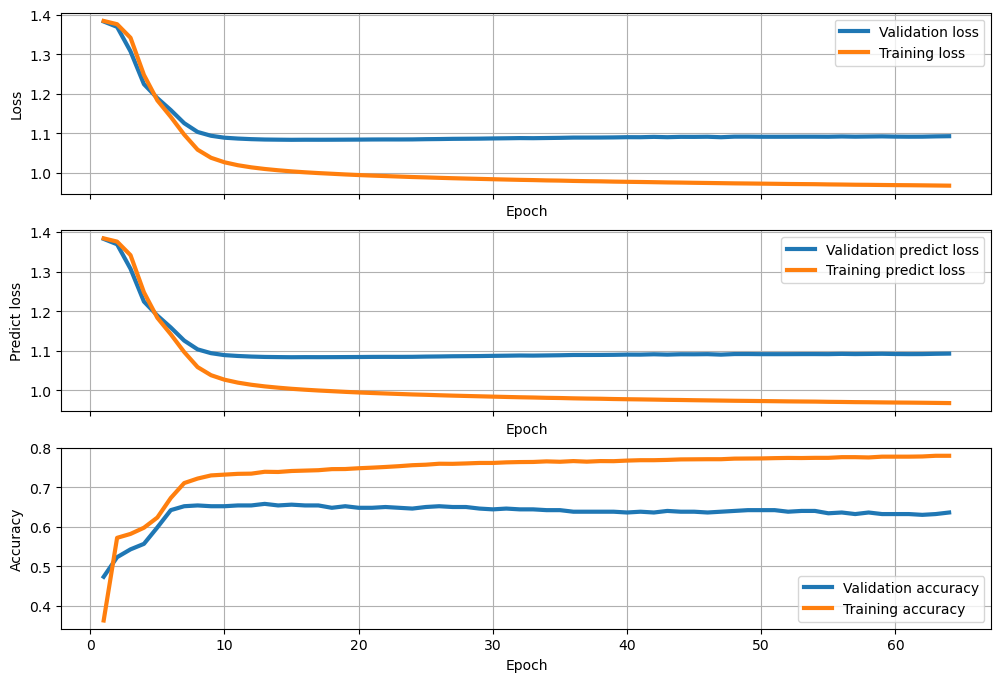

In [96]:
plot_history(hist)

In [97]:
test_metrics = validate(pred_model, test_dl, pred_loss)

print(get_metrics_str(test_metrics, 'test_'))

test_loss: 1.0945 - test_predict_loss: 1.0945 - test_accuracy: 0.6402


In [98]:
y_pred, y_true = predict(pred_model, test_dl, return_class=True)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81       121
           1       0.60      0.64      0.62       124
           2       0.57      0.55      0.56       119
           3       0.58      0.60      0.59       139

    accuracy                           0.64       503
   macro avg       0.65      0.64      0.64       503
weighted avg       0.64      0.64      0.64       503



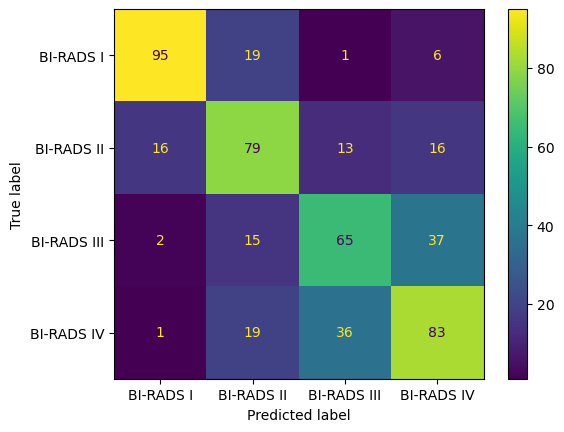

In [99]:
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=IrmaDataset.irma_classmap.classes_
)
cm_display.plot()

# Laplacian Dataset (add)

In [5]:
dataset = IrmaDataset(
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            MinMaxScaler(),
            Laplacian('add', kernel='negative'),
            MinMaxScaler()
        ]
    ),
    return_images=True,
)

datasets = train_val_split(dataset, 0.1, random_state=7)
datasets['test'] = datasets['val']
datasets = {**datasets, **train_val_split(datasets['train'], 0.1 / 0.9, random_state=7)}

dataloaders = {
    x: DataLoader(datasets[x], batch_size, shuffle=True)
    for x in ['train', 'test', 'val']
}

len(datasets['train']), len(datasets['test']), len(datasets['val'])

(4018, 503, 503)

In [13]:
ex_images.append(get_sample_images(datasets['test']))

In [14]:
len(ex_images)

4

In [15]:
ex_images[0][0][0].shape

torch.Size([1, 128, 128])

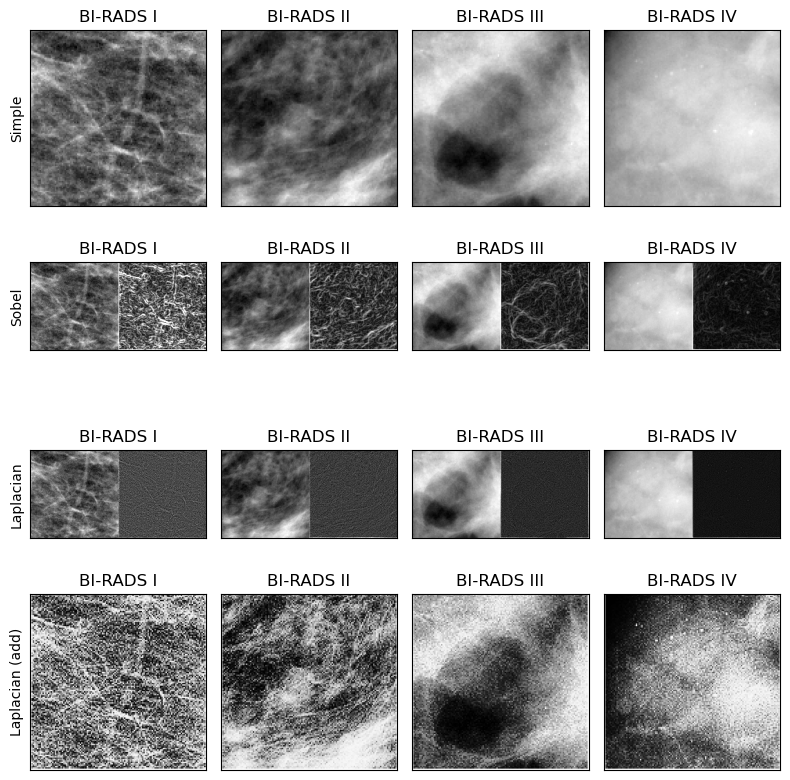

In [16]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(4, 4, figsize=(8, 8))  # Create subplots for individual images
ds_name = ['Simple', 'Sobel', 'Laplacian', 'Laplacian (add)']

for j, samples in enumerate(ex_images):
    for i, (im, l) in enumerate(samples):
        label = IrmaDataset.get_class_label([l])
        im = im.permute(1, 2, 0)

        plot_borders = im.shape[-1] == 2

        if plot_borders:
            image = im[:, :, :-1]
            border = im[:, :, -1]
        else:
            image = im
            
        if plot_borders:
            combined_image = np.concatenate((image.flatten(1), border), axis=1)
            axes[j, i].imshow(combined_image, cmap='gray')  # Apply cmap
        else:
            axes[j, i].imshow(image, cmap='gray')  # Apply cmap

        if i == 0:
            axes[j, i].set_ylabel(ds_name[j])

        axes[j, i].set_yticks([])
        axes[j, i].set_xticks([])
        axes[j, i].set_title(str(label[0]))  # Set label as title for each image

# fig.suptitle(f'Grid of {n} Images with Labels', fontsize=16)  # Add overall title
plt.tight_layout()
plt.show()

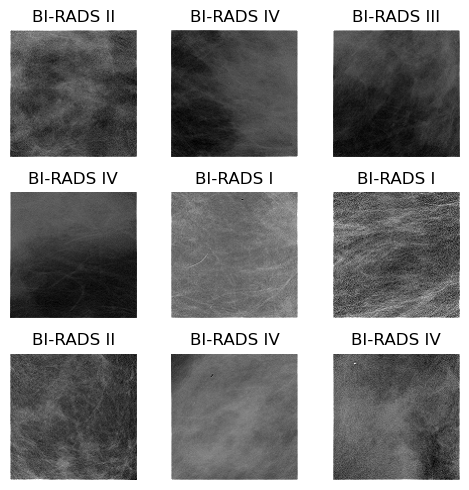

In [6]:
sample_images(dataloaders['train'], label_mapper=IrmaDataset.get_class_label, plot_borders=False)

## VAE

In [102]:
model = VAE(
    latent_dim=64,
    n_channels=1,
    conv_layers=[(5, 192), (3, 128), (3, 96), (3, 64)],
    conv_pooling=[2, 2, 2, 2],
    linear_input=(64, 6, 6),
    linear_layers=[256, 128, 64],
    clamp_output=False,
    use_batchnorm=True
)
summary(model, input_size=(32, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [32, 1, 128, 128]         --
├─Encoder: 1-1                           [32, 64]                  --
│    └─Sequential: 2-1                   [32, 64, 6, 6]            --
│    │    └─Conv2d: 3-1                  [32, 192, 124, 124]       4,992
│    │    └─BatchNorm2d: 3-2             [32, 192, 124, 124]       384
│    │    └─GELU: 3-3                    [32, 192, 124, 124]       --
│    │    └─MaxPool2d: 3-4               [32, 192, 62, 62]         --
│    │    └─Conv2d: 3-5                  [32, 128, 60, 60]         221,312
│    │    └─BatchNorm2d: 3-6             [32, 128, 60, 60]         256
│    │    └─GELU: 3-7                    [32, 128, 60, 60]         --
│    │    └─MaxPool2d: 3-8               [32, 128, 30, 30]         --
│    │    └─Conv2d: 3-9                  [32, 96, 28, 28]          110,688
│    │    └─BatchNorm2d: 3-10            [32, 96, 28, 28]          192

In [103]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(model.parameters())
model.to(device)

hist = train(model, optimizer, dataloaders['train'], dataloaders['val'], 32, kl_reconstruction_loss)

[epoch: 1] train_loss: 24.7114 - train_rec_loss: 24.6874 - train_kl_loss: 0.0240 - val_loss: 7.1725 - val_rec_loss: 7.1162 - val_kl_loss: 0.0563
[epoch: 2] train_loss: 6.7322 - train_rec_loss: 6.6819 - train_kl_loss: 0.0503 - val_loss: 6.3942 - val_rec_loss: 6.3383 - val_kl_loss: 0.0560
[epoch: 3] train_loss: 6.2345 - train_rec_loss: 6.1809 - train_kl_loss: 0.0535 - val_loss: 5.9986 - val_rec_loss: 5.9435 - val_kl_loss: 0.0551
[epoch: 4] train_loss: 5.8989 - train_rec_loss: 5.8412 - train_kl_loss: 0.0577 - val_loss: 5.8163 - val_rec_loss: 5.7546 - val_kl_loss: 0.0617
[epoch: 5] train_loss: 5.7530 - train_rec_loss: 5.6941 - train_kl_loss: 0.0589 - val_loss: 5.7559 - val_rec_loss: 5.6934 - val_kl_loss: 0.0625
[epoch: 6] train_loss: 5.6286 - train_rec_loss: 5.5684 - train_kl_loss: 0.0601 - val_loss: 5.6179 - val_rec_loss: 5.5586 - val_kl_loss: 0.0593
[epoch: 7] train_loss: 5.5714 - train_rec_loss: 5.5121 - train_kl_loss: 0.0593 - val_loss: 5.6145 - val_rec_loss: 5.5555 - val_kl_loss: 0.05

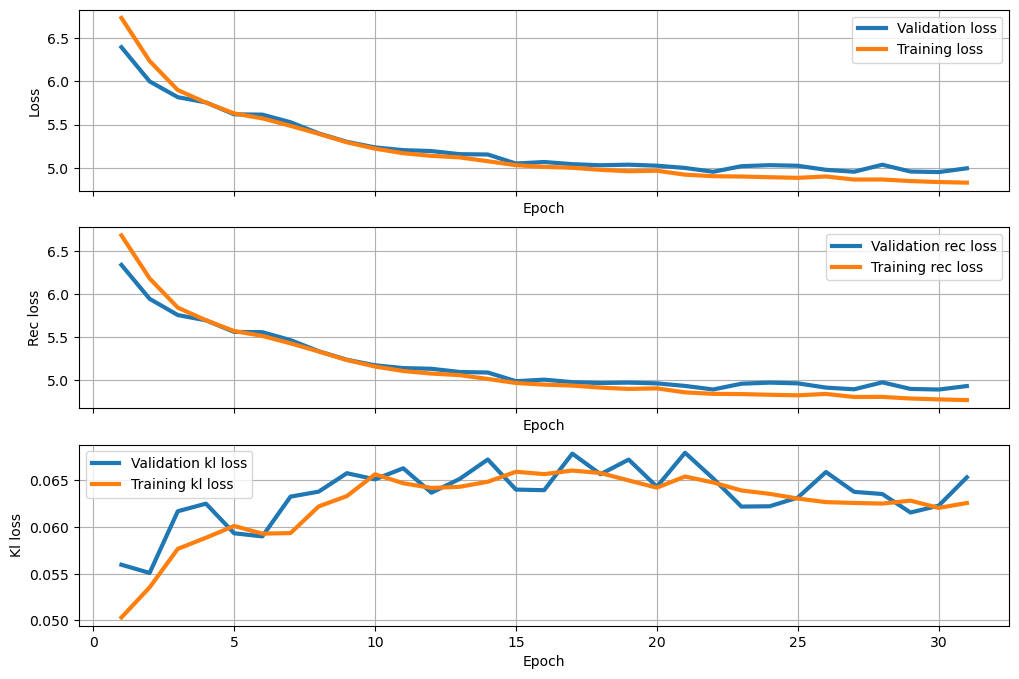

In [104]:
plot_history(hist[1:])

In [105]:
torch.save((model.kwargs ,model.state_dict()), "models/final/laplacian_inplace/vae.pt")

test_loss: 4.9103 - test_rec_loss: 4.8443 - test_kl_loss: 0.0661


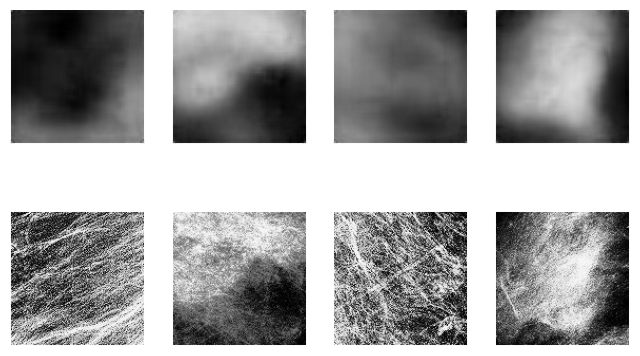

In [106]:
test_metrics = validate(model, dataloaders['test'], kl_reconstruction_loss)

print(get_metrics_str(test_metrics, 'test_'))

plot_reconstructions(model, dataloaders['test'], plot_borders=False)

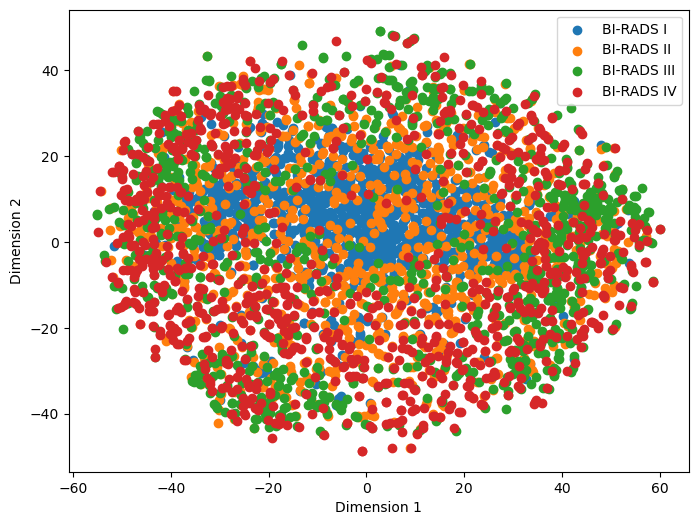

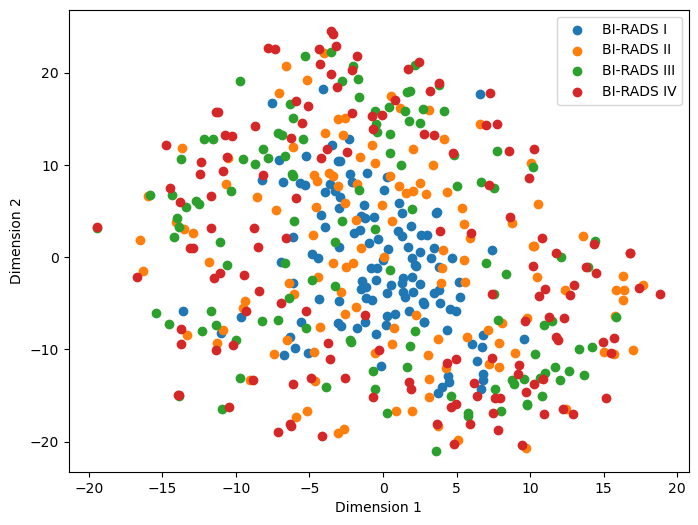

In [107]:
train_latent, train_labels = get_latent(model, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(model, dataloaders["test"], IrmaDataset.get_class_label)

tsne = TSNE()
train_tsne_latent = tsne.fit_transform(train_latent, train_labels)
tsne_latent = tsne.fit_transform(latent)

plot_2d(train_tsne_latent, train_labels, 'tab10', IrmaDataset.get_class_label_value)
plot_2d(tsne_latent, labels, 'tab10', IrmaDataset.get_class_label_value)

In [108]:
train_latent, train_labels = get_latent(model, dataloaders["train"])
val_latent, val_labels = get_latent(model, dataloaders["val"])
latent, labels = get_latent(model, dataloaders["test"])

In [109]:
train_latent, train_labels = train_latent.astype('float32'), train_labels.astype('int64')
val_latent, val_labels = val_latent.astype('float32'), val_labels.astype('int64')
latent, labels = latent.astype('float32'), labels.astype('int64')

In [110]:
train_ds = TensorDataset(torch.tensor(train_latent), torch.tensor(train_labels))
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

val_ds = TensorDataset(torch.tensor(val_latent), torch.tensor(val_labels))
val_dl = DataLoader(val_ds, batch_size)

test_ds = TensorDataset(torch.tensor(latent), torch.tensor(labels))
test_dl = DataLoader(test_ds, batch_size)

In [111]:
pred_model = torch.nn.Sequential(
    torch.nn.Linear(64, 128),
    torch.nn.GELU(),
    torch.nn.Linear(128, 256),
    torch.nn.GELU(),
    torch.nn.Linear(256, 128),
    torch.nn.GELU(),
    torch.nn.Linear(128, 64),
    torch.nn.GELU(),
    torch.nn.Linear(64, 4),
    torch.nn.Softmax(-1)
)

summary(pred_model, (32, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 4]                   --
├─Linear: 1-1                            [32, 128]                 8,320
├─GELU: 1-2                              [32, 128]                 --
├─Linear: 1-3                            [32, 256]                 33,024
├─GELU: 1-4                              [32, 256]                 --
├─Linear: 1-5                            [32, 128]                 32,896
├─GELU: 1-6                              [32, 128]                 --
├─Linear: 1-7                            [32, 64]                  8,256
├─GELU: 1-8                              [32, 64]                  --
├─Linear: 1-9                            [32, 4]                   260
├─Softmax: 1-10                          [32, 4]                   --
Total params: 82,756
Trainable params: 82,756
Non-trainable params: 0
Total mult-adds (M): 2.65
Input size (MB): 0.01
Forward/backward pass 

In [112]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(pred_model.parameters(), lr=0.00002)
pred_model.to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

hist = train(pred_model, optimizer, train_dl, val_dl, 64, pred_loss)

[epoch: 1] train_loss: 1.3861 - train_predict_loss: 1.3861 - train_accuracy: 0.2466 - val_loss: 1.3848 - val_predict_loss: 1.3848 - val_accuracy: 0.2803
[epoch: 2] train_loss: 1.3848 - train_predict_loss: 1.3848 - train_accuracy: 0.2466 - val_loss: 1.3832 - val_predict_loss: 1.3832 - val_accuracy: 0.2803
[epoch: 3] train_loss: 1.3816 - train_predict_loss: 1.3816 - train_accuracy: 0.2638 - val_loss: 1.3783 - val_predict_loss: 1.3783 - val_accuracy: 0.3340
[epoch: 4] train_loss: 1.3714 - train_predict_loss: 1.3714 - train_accuracy: 0.3367 - val_loss: 1.3642 - val_predict_loss: 1.3642 - val_accuracy: 0.3062
[epoch: 5] train_loss: 1.3501 - train_predict_loss: 1.3501 - train_accuracy: 0.3133 - val_loss: 1.3489 - val_predict_loss: 1.3489 - val_accuracy: 0.3221
[epoch: 6] train_loss: 1.3359 - train_predict_loss: 1.3359 - train_accuracy: 0.3532 - val_loss: 1.3415 - val_predict_loss: 1.3415 - val_accuracy: 0.3618
[epoch: 7] train_loss: 1.3271 - train_predict_loss: 1.3271 - train_accuracy: 0.411

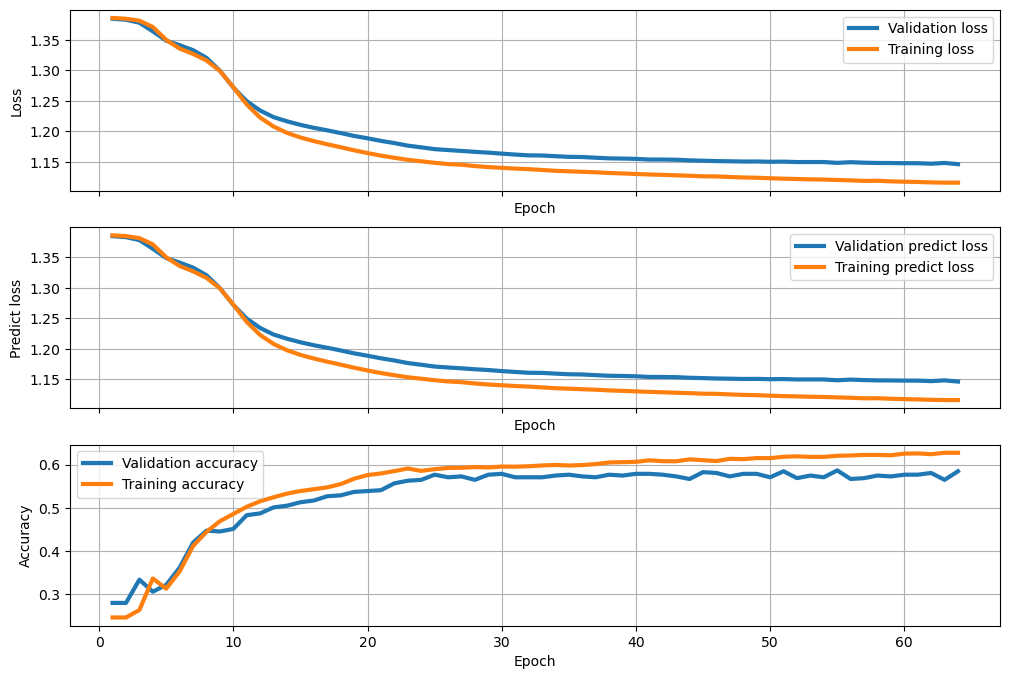

In [113]:
plot_history(hist)

In [114]:
test_metrics = validate(pred_model, test_dl, pred_loss)

print(get_metrics_str(test_metrics, 'test_'))

test_loss: 1.1672 - test_predict_loss: 1.1672 - test_accuracy: 0.5567


In [115]:
y_pred, y_true = predict(pred_model, test_dl, return_class=True)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.72      0.75       121
           1       0.46      0.46      0.46       124
           2       0.46      0.55      0.50       119
           3       0.56      0.51      0.54       139

    accuracy                           0.56       503
   macro avg       0.57      0.56      0.56       503
weighted avg       0.57      0.56      0.56       503



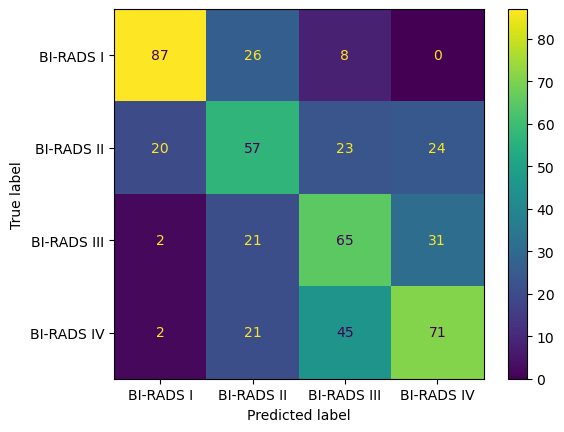

In [116]:
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=IrmaDataset.irma_classmap.classes_
)
cm_display.plot()

## PVAE

In [7]:
model = PVAE(
    latent_dim=64,
    n_channels=1,
    n_classes=4,
    conv_layers=[(5, 192), (3, 128), (3, 96), (3, 64)],
    conv_pooling=[2, 2, 2, 2],
    linear_input=(64, 6, 6),
    linear_layers=[256, 128, 64],
    pred_layers=[128, 64],
    clamp_output=False,
    use_batchnorm=True
)
summary(model, input_size=(32, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
PVAE                                     [32, 1, 128, 128]         --
├─Encoder: 1-1                           [32, 64]                  --
│    └─Sequential: 2-1                   [32, 64, 6, 6]            --
│    │    └─Conv2d: 3-1                  [32, 192, 124, 124]       4,992
│    │    └─BatchNorm2d: 3-2             [32, 192, 124, 124]       384
│    │    └─GELU: 3-3                    [32, 192, 124, 124]       --
│    │    └─MaxPool2d: 3-4               [32, 192, 62, 62]         --
│    │    └─Conv2d: 3-5                  [32, 128, 60, 60]         221,312
│    │    └─BatchNorm2d: 3-6             [32, 128, 60, 60]         256
│    │    └─GELU: 3-7                    [32, 128, 60, 60]         --
│    │    └─MaxPool2d: 3-8               [32, 128, 30, 30]         --
│    │    └─Conv2d: 3-9                  [32, 96, 28, 28]          110,688
│    │    └─BatchNorm2d: 3-10            [32, 96, 28, 28]          192

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(model.parameters())
model.to(device)

hist = train(model, optimizer, dataloaders['train'], dataloaders['val'], 32, pred_kl_reconstruction_loss)

[epoch: 1] train_loss: 14.1700 - train_rec_loss: 12.7712 - train_kl_loss: 0.0187 - train_pred_loss: 1.3800 - train_accuracy: 0.2670 - val_loss: 2.6801 - val_rec_loss: 1.2909 - val_kl_loss: 0.0185 - val_pred_loss: 1.3706 - val_accuracy: 0.2922
[epoch: 2] train_loss: 2.4985 - train_rec_loss: 1.1981 - train_kl_loss: 0.0248 - train_pred_loss: 1.2756 - train_accuracy: 0.4465 - val_loss: 2.3971 - val_rec_loss: 1.1289 - val_kl_loss: 0.0248 - val_pred_loss: 1.2434 - val_accuracy: 0.4831
[epoch: 3] train_loss: 2.2509 - train_rec_loss: 1.0238 - train_kl_loss: 0.0305 - train_pred_loss: 1.1966 - train_accuracy: 0.5266 - val_loss: 2.2273 - val_rec_loss: 0.9959 - val_kl_loss: 0.0313 - val_pred_loss: 1.2000 - val_accuracy: 0.5229
[epoch: 4] train_loss: 2.1482 - train_rec_loss: 0.9466 - train_kl_loss: 0.0313 - train_pred_loss: 1.1703 - train_accuracy: 0.5587 - val_loss: 2.1241 - val_rec_loss: 0.9061 - val_kl_loss: 0.0367 - val_pred_loss: 1.1814 - val_accuracy: 0.5467
[epoch: 5] train_loss: 2.0659 - tr

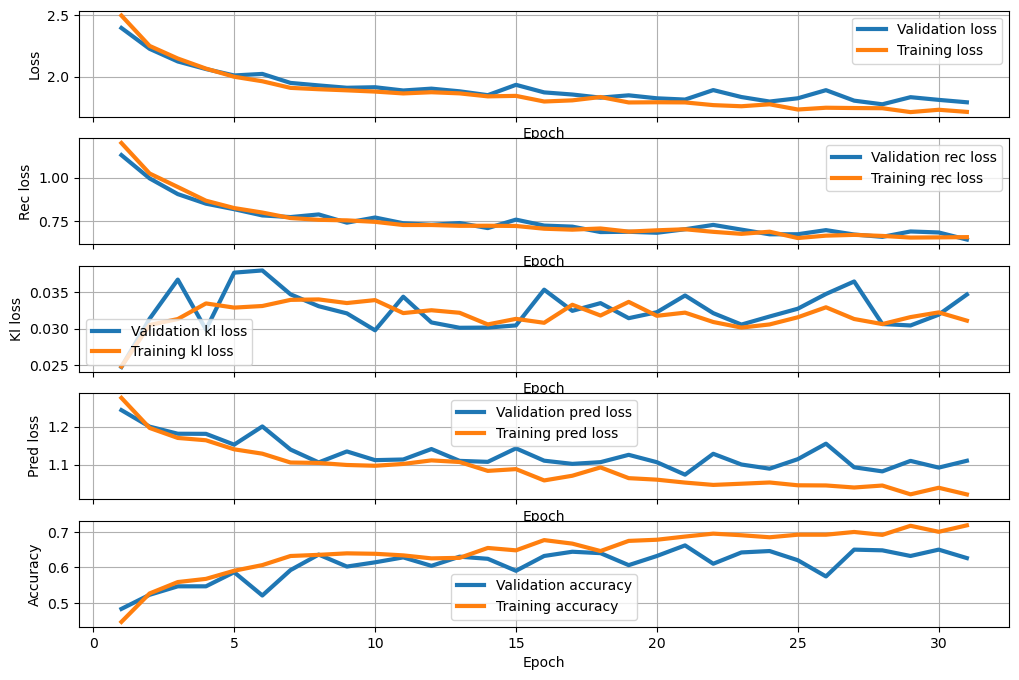

In [9]:
plot_history(hist[1:])

In [120]:
torch.save((model.kwargs ,model.state_dict()), "models/final/laplacian_inplace/pvae.pt")

test_loss: 1.8026 - test_rec_loss: 0.6461 - test_kl_loss: 0.0347 - test_pred_loss: 1.1218 - test_accuracy: 0.6163


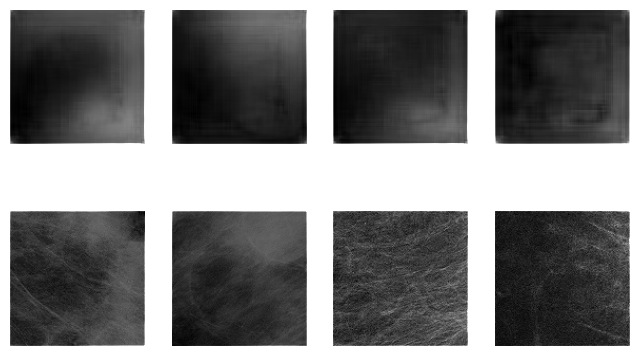

In [10]:
test_metrics = validate(model, dataloaders['test'], pred_kl_reconstruction_loss)

print(get_metrics_str(test_metrics, 'test_'))

plot_reconstructions(model, dataloaders['test'], plot_borders=False)

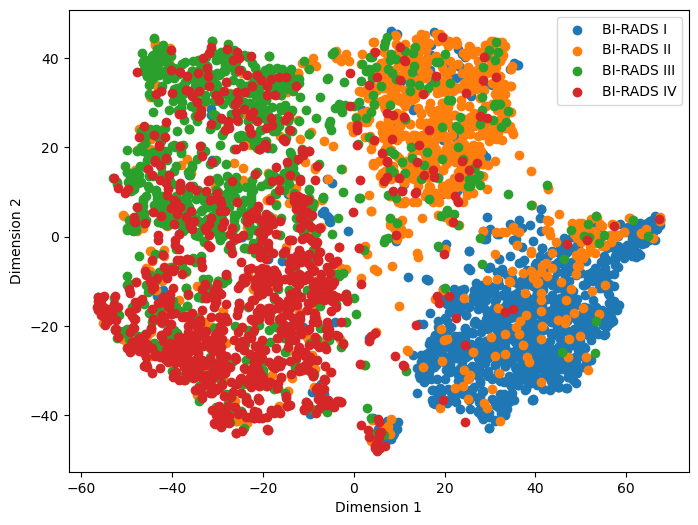

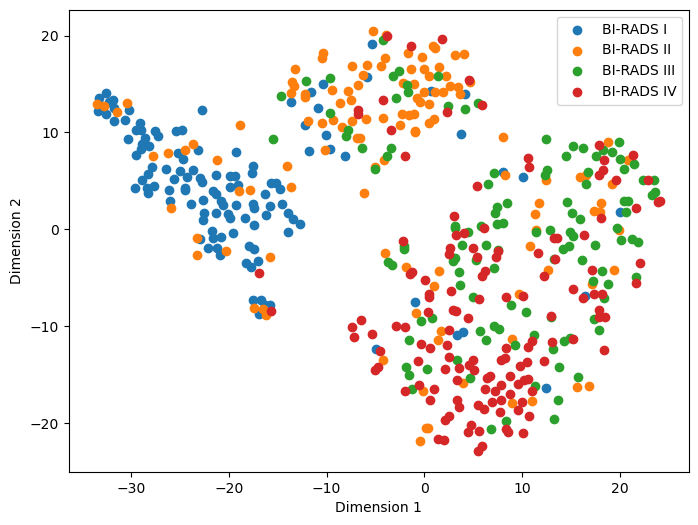

In [11]:
train_latent, train_labels = get_latent(model, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(model, dataloaders["test"], IrmaDataset.get_class_label)

tsne = TSNE()
train_tsne_latent = tsne.fit_transform(train_latent, train_labels)
tsne_latent = tsne.fit_transform(latent)

plot_2d(train_tsne_latent, train_labels, 'tab10', IrmaDataset.get_class_label_value)
plot_2d(tsne_latent, labels, 'tab10', IrmaDataset.get_class_label_value)

In [12]:
train_latent, train_labels = get_latent(model, dataloaders["train"])
val_latent, val_labels = get_latent(model, dataloaders["val"])
latent, labels = get_latent(model, dataloaders["test"])

In [13]:
train_latent, train_labels = train_latent.astype('float32'), train_labels.astype('int64')
val_latent, val_labels = val_latent.astype('float32'), val_labels.astype('int64')
latent, labels = latent.astype('float32'), labels.astype('int64')

In [14]:
train_ds = TensorDataset(torch.tensor(train_latent), torch.tensor(train_labels))
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

val_ds = TensorDataset(torch.tensor(val_latent), torch.tensor(val_labels))
val_dl = DataLoader(val_ds, batch_size)

test_ds = TensorDataset(torch.tensor(latent), torch.tensor(labels))
test_dl = DataLoader(test_ds, batch_size)

In [15]:
pred_model = torch.nn.Sequential(
    torch.nn.Linear(64, 512),
    torch.nn.GELU(),
    torch.nn.Linear(512, 256),
    torch.nn.GELU(),
    torch.nn.Linear(256, 128),
    torch.nn.GELU(),
    torch.nn.Linear(128, 64),
    torch.nn.GELU(),
    torch.nn.Linear(64, 4),
    torch.nn.Softmax(-1)
)

summary(pred_model, (32, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 4]                   --
├─Linear: 1-1                            [32, 512]                 33,280
├─GELU: 1-2                              [32, 512]                 --
├─Linear: 1-3                            [32, 256]                 131,328
├─GELU: 1-4                              [32, 256]                 --
├─Linear: 1-5                            [32, 128]                 32,896
├─GELU: 1-6                              [32, 128]                 --
├─Linear: 1-7                            [32, 64]                  8,256
├─GELU: 1-8                              [32, 64]                  --
├─Linear: 1-9                            [32, 4]                   260
├─Softmax: 1-10                          [32, 4]                   --
Total params: 206,020
Trainable params: 206,020
Non-trainable params: 0
Total mult-adds (M): 6.59
Input size (MB): 0.01
Forward/backward p

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(pred_model.parameters(), lr=0.000005)
pred_model.to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

hist = train(pred_model, optimizer, train_dl, val_dl, 64, pred_loss)

[epoch: 1] train_loss: 1.3853 - train_predict_loss: 1.3853 - train_accuracy: 0.3484 - val_loss: 1.3859 - val_predict_loss: 1.3859 - val_accuracy: 0.4394
[epoch: 2] train_loss: 1.3831 - train_predict_loss: 1.3831 - train_accuracy: 0.4669 - val_loss: 1.3837 - val_predict_loss: 1.3837 - val_accuracy: 0.4573
[epoch: 3] train_loss: 1.3801 - train_predict_loss: 1.3801 - train_accuracy: 0.4801 - val_loss: 1.3804 - val_predict_loss: 1.3804 - val_accuracy: 0.4692
[epoch: 4] train_loss: 1.3754 - train_predict_loss: 1.3754 - train_accuracy: 0.5234 - val_loss: 1.3751 - val_predict_loss: 1.3751 - val_accuracy: 0.4930
[epoch: 5] train_loss: 1.3675 - train_predict_loss: 1.3675 - train_accuracy: 0.5665 - val_loss: 1.3660 - val_predict_loss: 1.3660 - val_accuracy: 0.5149
[epoch: 6] train_loss: 1.3536 - train_predict_loss: 1.3536 - train_accuracy: 0.5881 - val_loss: 1.3498 - val_predict_loss: 1.3498 - val_accuracy: 0.5189
[epoch: 7] train_loss: 1.3293 - train_predict_loss: 1.3293 - train_accuracy: 0.592

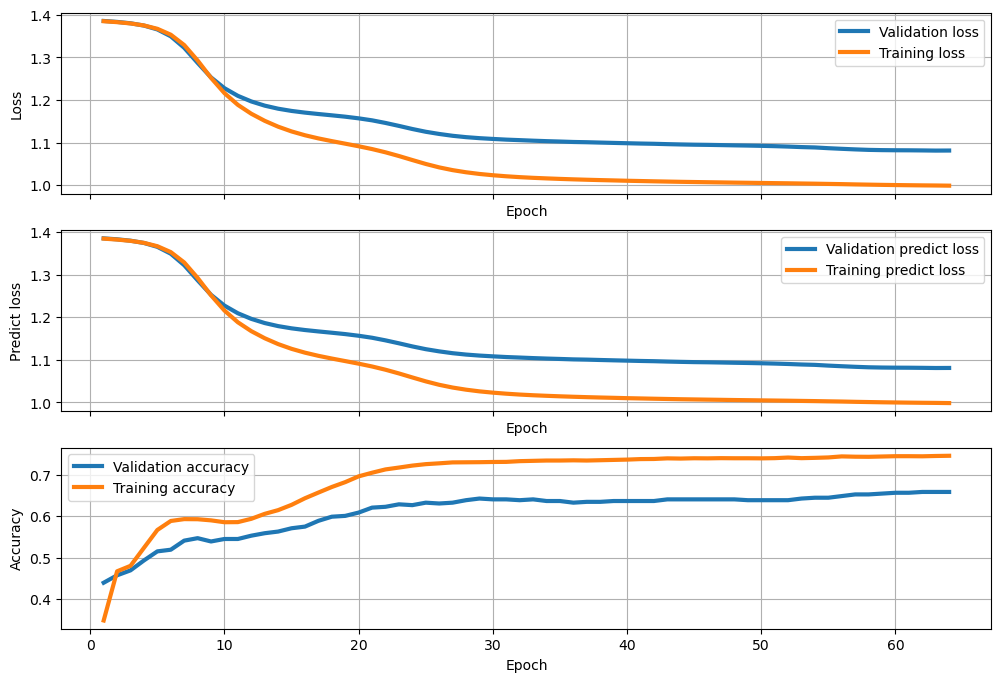

In [17]:
plot_history(hist)

In [18]:
test_metrics = validate(pred_model, test_dl, pred_loss)

print(get_metrics_str(test_metrics, 'test_'))

test_loss: 1.1266 - test_predict_loss: 1.1266 - test_accuracy: 0.6083


In [19]:
y_pred, y_true = predict(pred_model, test_dl, return_class=True)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.80      0.80       121
           1       0.55      0.53      0.54       124
           2       0.50      0.50      0.50       119
           3       0.60      0.60      0.60       139

    accuracy                           0.61       503
   macro avg       0.61      0.61      0.61       503
weighted avg       0.61      0.61      0.61       503



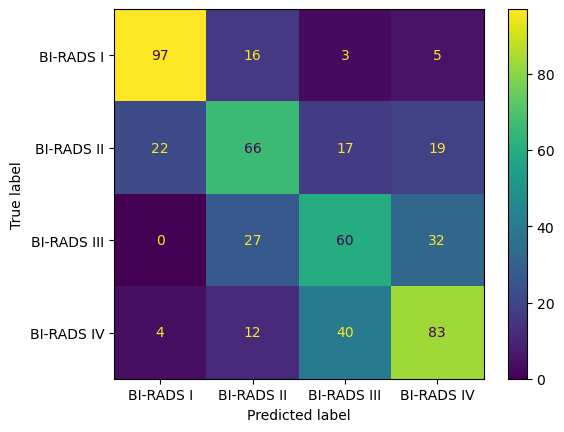

In [20]:
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=IrmaDataset.irma_classmap.classes_
)
cm_display.plot()